# Semi-supervised surgery pipeline with SCANVI

In [1]:
import os
import gdown

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import scanpy as sc
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity

import pynndescent
from scvi.model.utils import mde

 captum (see https://github.com/pytorch/captum).


In [2]:
def plot_training_history(history, keys):
    """
    Plots the training history for the specified keys in a grid layout.
    
    Parameters:
    - history: dict, containing the training history.
    - keys: list of str, the keys to plot from the history.
    """
    num_plots = len(keys)
    grid_size = int(np.ceil(np.sqrt(num_plots)))

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axes = axes.flatten()

    for idx, key in enumerate(keys):
        if key in history:
            axes[idx].plot(history[key])
            axes[idx].set_title(key)
        else:
            axes[idx].set_title(f"{key} not found")
        axes[idx].grid(True)

    for idx in range(num_plots, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
# TODO maybe this is what achieved high accuracy>
torch.set_float32_matmul_precision("high")
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### IMPORTANT THIS IS WHERE WE CHOOSE THE CELL TYPE LABEL TO TRAIN ON

In [4]:
condition_key = 'dataset'
cell_type_key = 'cell_type_tumor'

## Set relevant anndata.obs labels and training length

These are the filtering criteria we used for only having tumor tissue, and enriched datasets for only one type

In [5]:
# adata = sc.read_h5ad('/root/datos/maestria/netopaas/luca/data/atlas/extended.h5ad')

# adata = adata[(adata.obs.origin == 'tumor_primary')]

# # stages = ['III','III or IV', 'IV']
# stages = ['I','II','III','III or IV', 'IV']
# adata = adata[adata.obs.uicc_stage.isin(stages)]

# # we remove these because some are enriched for endotheliar and some for immune cells
# studies = ['Goveia_Carmeliet_2020','Leader_Merad_2021','Guo_Zhang_2018']
# adata = adata[~adata.obs.study.isin(studies)]

# adata = adata[:, adata.var.is_highly_variable == 'True']

# import gc
# del adata.raw
# gc.collect()

# del adata.layers['counts_length_scaled']
# adata.X = adata.layers['count'].copy()

# adata

In [16]:
# adata.write_h5ad('/root/datos/maestria/netopaas/luca/data/atlas/extended_tumor_hvg.h5ad')
adata = sc.read_h5ad('/root/datos/maestria/netopaas/luca/data/atlas/extended_tumor_hvg.h5ad')

In [22]:
adata.obs.study.cat.categories

Index(['Chen_Zhang_2020', 'He_Fan_2021', 'Kim_Lee_2020',
       'Lambrechts_Thienpont_2018', 'Laughney_Massague_2020',
       'Maynard_Bivona_2020', 'UKIM-V', 'Wu_Zhou_2021', 'Zilionis_Klein_2019'],
      dtype='object')

In [19]:
# adata = remove_sparsity(adata)
source_adata = adata

## Create SCANVI model and train it on fully labelled reference dataset

In [7]:
# Does scVI
sca.models.SCVI.setup_anndata(source_adata, labels_key=cell_type_key,
                             batch_key=condition_key # HCLA atlas did not correct for sample,
                              # as they wanted to maintain variability
                             )

/usr/local/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [9]:
source_adata.obs

sample uicc_stage ever_smoker  \
AAACCCAAGAGCCATG-1_0-1    Chen_Zhang_2020_NSCLC-10        III         NaN   
AAACCCAAGATTAGAC-1_0-1    Chen_Zhang_2020_NSCLC-10        III         NaN   
AAACCCAAGGTCGCCT-1_0-1    Chen_Zhang_2020_NSCLC-10        III         NaN   
AAACCCAAGTCATTGC-1_0-1    Chen_Zhang_2020_NSCLC-10        III         NaN   
AAACCCACACGGATCC-1_0-1    Chen_Zhang_2020_NSCLC-10        III         NaN   
...                                            ...        ...         ...   
811511_27-3             UKIM-V-2_P17_tumor_primary          I         yes   
468397_27-3             UKIM-V-2_P17_tumor_primary          I         yes   
115884_27-3             UKIM-V-2_P17_tumor_primary          I         yes   
201201_27-3             UKIM-V-2_P17_tumor_primary          I         yes   
194204_27-3             UKIM-V-2_P17_tumor_primary          I         yes   

                         age                  donor_id         origin  \
AAACCCAAGAGCCATG-1_0-1   NaN  Chen_Zhang_2020_NSCLC-10  tumor_primary   
AAACCCAAGATTAGAC-1_0-1   NaN  Chen_Zhang_2020_NSCLC-10  tumor_primary   
AAACCCAAGGTCGCCT-1_0-1   NaN  Chen_Zhang_2020_NSCLC-10  tumor_primary   
AAACCCAAGTCATTGC-1_0-1   NaN  Chen_Zhang_2020_NSCLC-10  tumor_primary   
AAACCCACACGGATCC-1_0-1   NaN  Chen_Zhang_2020_NSCLC-10  tumor_primary   
...                      ...                       ...            ...   
811511_27-3             60.0              UKIM-V-2_P17  tumor_primary   
468397_27-3             60.0              UKIM-V-2_P17  tumor_primary   
115884_27-3             60.0              UKIM-V-2_P17  tumor_primary   
201201_27-3             60.0              UKIM-V-2_P17  tumor_primary   
194204_27-3             60.0              UKIM-V-2_P17  tumor_primary   

                                dataset                    ann_fine  \
AAACCCAAGAGCCATG-1_0-1  Chen_Zhang_2020  T cell CD8 effector memory   
AAACCCAAGATTAGAC-1_0-1  Chen_Zhang_2020                Cancer cells   
AAACCCAAGGTCGCCT-1_0-1  Chen_Zhang_2020                      B cell   
AAACCCAAGTCATTGC-1_0-1  Chen_Zhang_2020                      B cell   
AAACCCACACGGATCC-1_0-1  Chen_Zhang_2020                 Plasma cell   
...                                 ...                         ...   
811511_27-3                    UKIM-V-2                 Neutrophils   
468397_27-3                    UKIM-V-2                 Neutrophils   
115884_27-3                    UKIM-V-2                 Neutrophils   
201201_27-3                    UKIM-V-2                 Neutrophils   
194204_27-3                    UKIM-V-2                 Neutrophils   

                              cell_type_predicted doublet_status  ...  \
AAACCCAAGAGCCATG-1_0-1                 T cell CD8        singlet  ...   
AAACCCAAGATTAGAC-1_0-1  Epithelial cell malignant        singlet  ...   
AAACCCAAGGTCGCCT-1_0-1                     B cell        singlet  ...   
AAACCCAAGTCATTGC-1_0-1                     B cell        singlet  ...   
AAACCCACACGGATCC-1_0-1                Plasma cell        singlet  ...   
...                                           ...            ...  ...   
811511_27-3                                   NaN        singlet  ...   
468397_27-3                                   NaN        singlet  ...   
115884_27-3                                   NaN        singlet  ...   
201201_27-3                                   NaN        singlet  ...   
194204_27-3                                   NaN        singlet  ...   

                                                           assay  \
AAACCCAAGAGCCATG-1_0-1                                 10x 3' v3   
AAACCCAAGATTAGAC-1_0-1                                 10x 3' v3   
AAACCCAAGGTCGCCT-1_0-1                                 10x 3' v3   
AAACCCAAGTCATTGC-1_0-1                                 10x 3' v3   
AAACCCACACGGATCC-1_0-1                                 10x 3' v3   
...                                                          ...   
811511_27-3             BD Rhapsody 

### b128_lay4_h1024_raydefaults

In [10]:
# elbo_trai is btter for converging and elbo is better for generalization.
# I would suggest, elbo_train for scVi and elbo for scANVI
early_stopping_kwargs = {
    "early_stopping_monitor": "elbo",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.01,
}
# This very importanto for actual covnergence... we have seen we tend to hit local minima and this helps in avoiding but only once...  a peridic approach would ve good
plan_kwargs= {
# "weight_decay": 0.0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.05,
}

vae = sca.models.SCVI(
    source_adata,
    n_layers=4,
    n_latent=10,
    n_hidden=1024,
    gene_likelihood='nb',  # Nb maybe may have less false postiives, because zinb zeros are complete technical zeroes which are not very realistic
    # use_layer_norm="both", # Reduces instability, in the encoder ad decoder phase, this is important because we could get zeroes
    use_batch_norm="none", # Normalize vlaues for bathc labels, like datsets... this is already enoded in the covariates
    encode_covariates=True, # This is essential considering batch effects.
    deeply_inject_covariates=False,  # Have more correlations between covariates, to make it more complex. 
)

In [11]:
# this levaes with litlle epochs and that does not achieve good accuracy
vae.train(max_epochs=100, early_stopping=early_stopping_kwargs, plan_kwargs=plan_kwargs, batch_size=128)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 74/100:  74%|███████████████████████████████████████████████████████████████████████▊                         | 74/100 [2:04:29<43:44, 100.94s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.41e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1475.706. Signaling Trainer to stop.


In [12]:
ref_path = '/root/datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_tumor_model_b128_lay4_h1024_raydefault/'
vae.save(ref_path, overwrite=True)

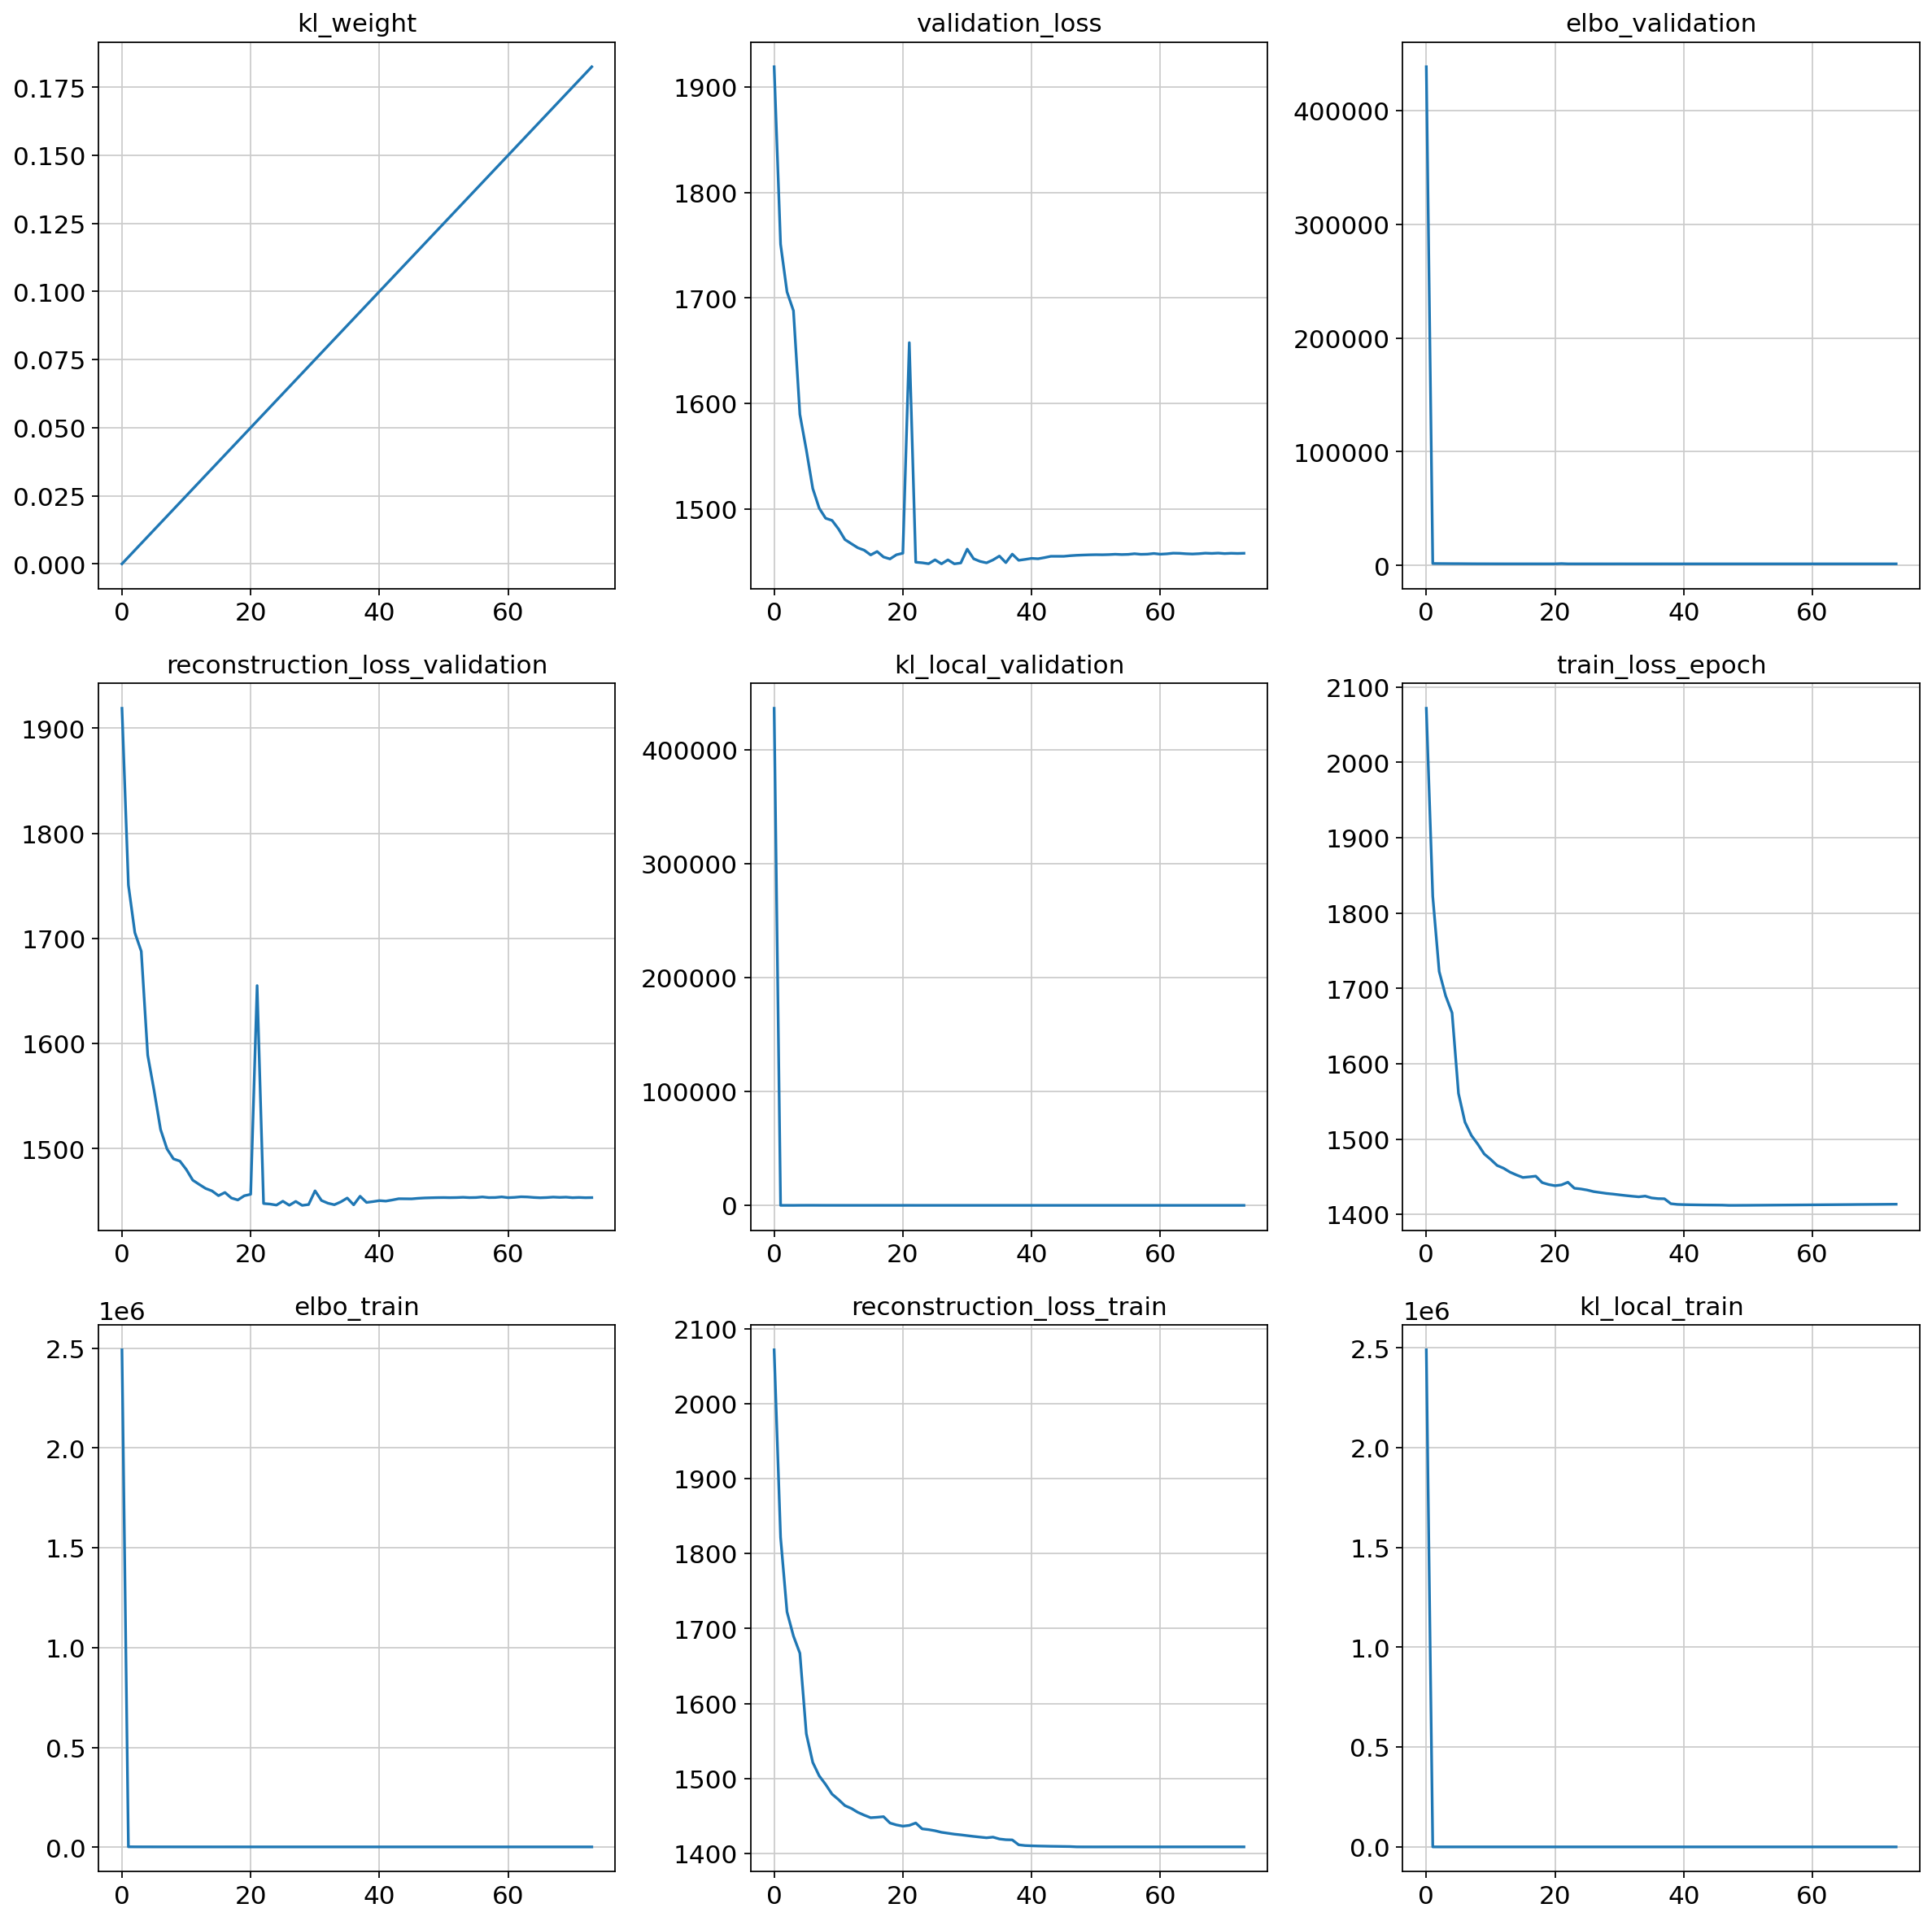

In [13]:
history_keys = [
    'kl_weight', 'validation_loss', 'elbo_validation', 
    'reconstruction_loss_validation', 'kl_local_validation', 
    'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 
    'kl_local_train'
]

# Assuming scanvae.history contains the training history
plot_training_history(vae.history, history_keys)

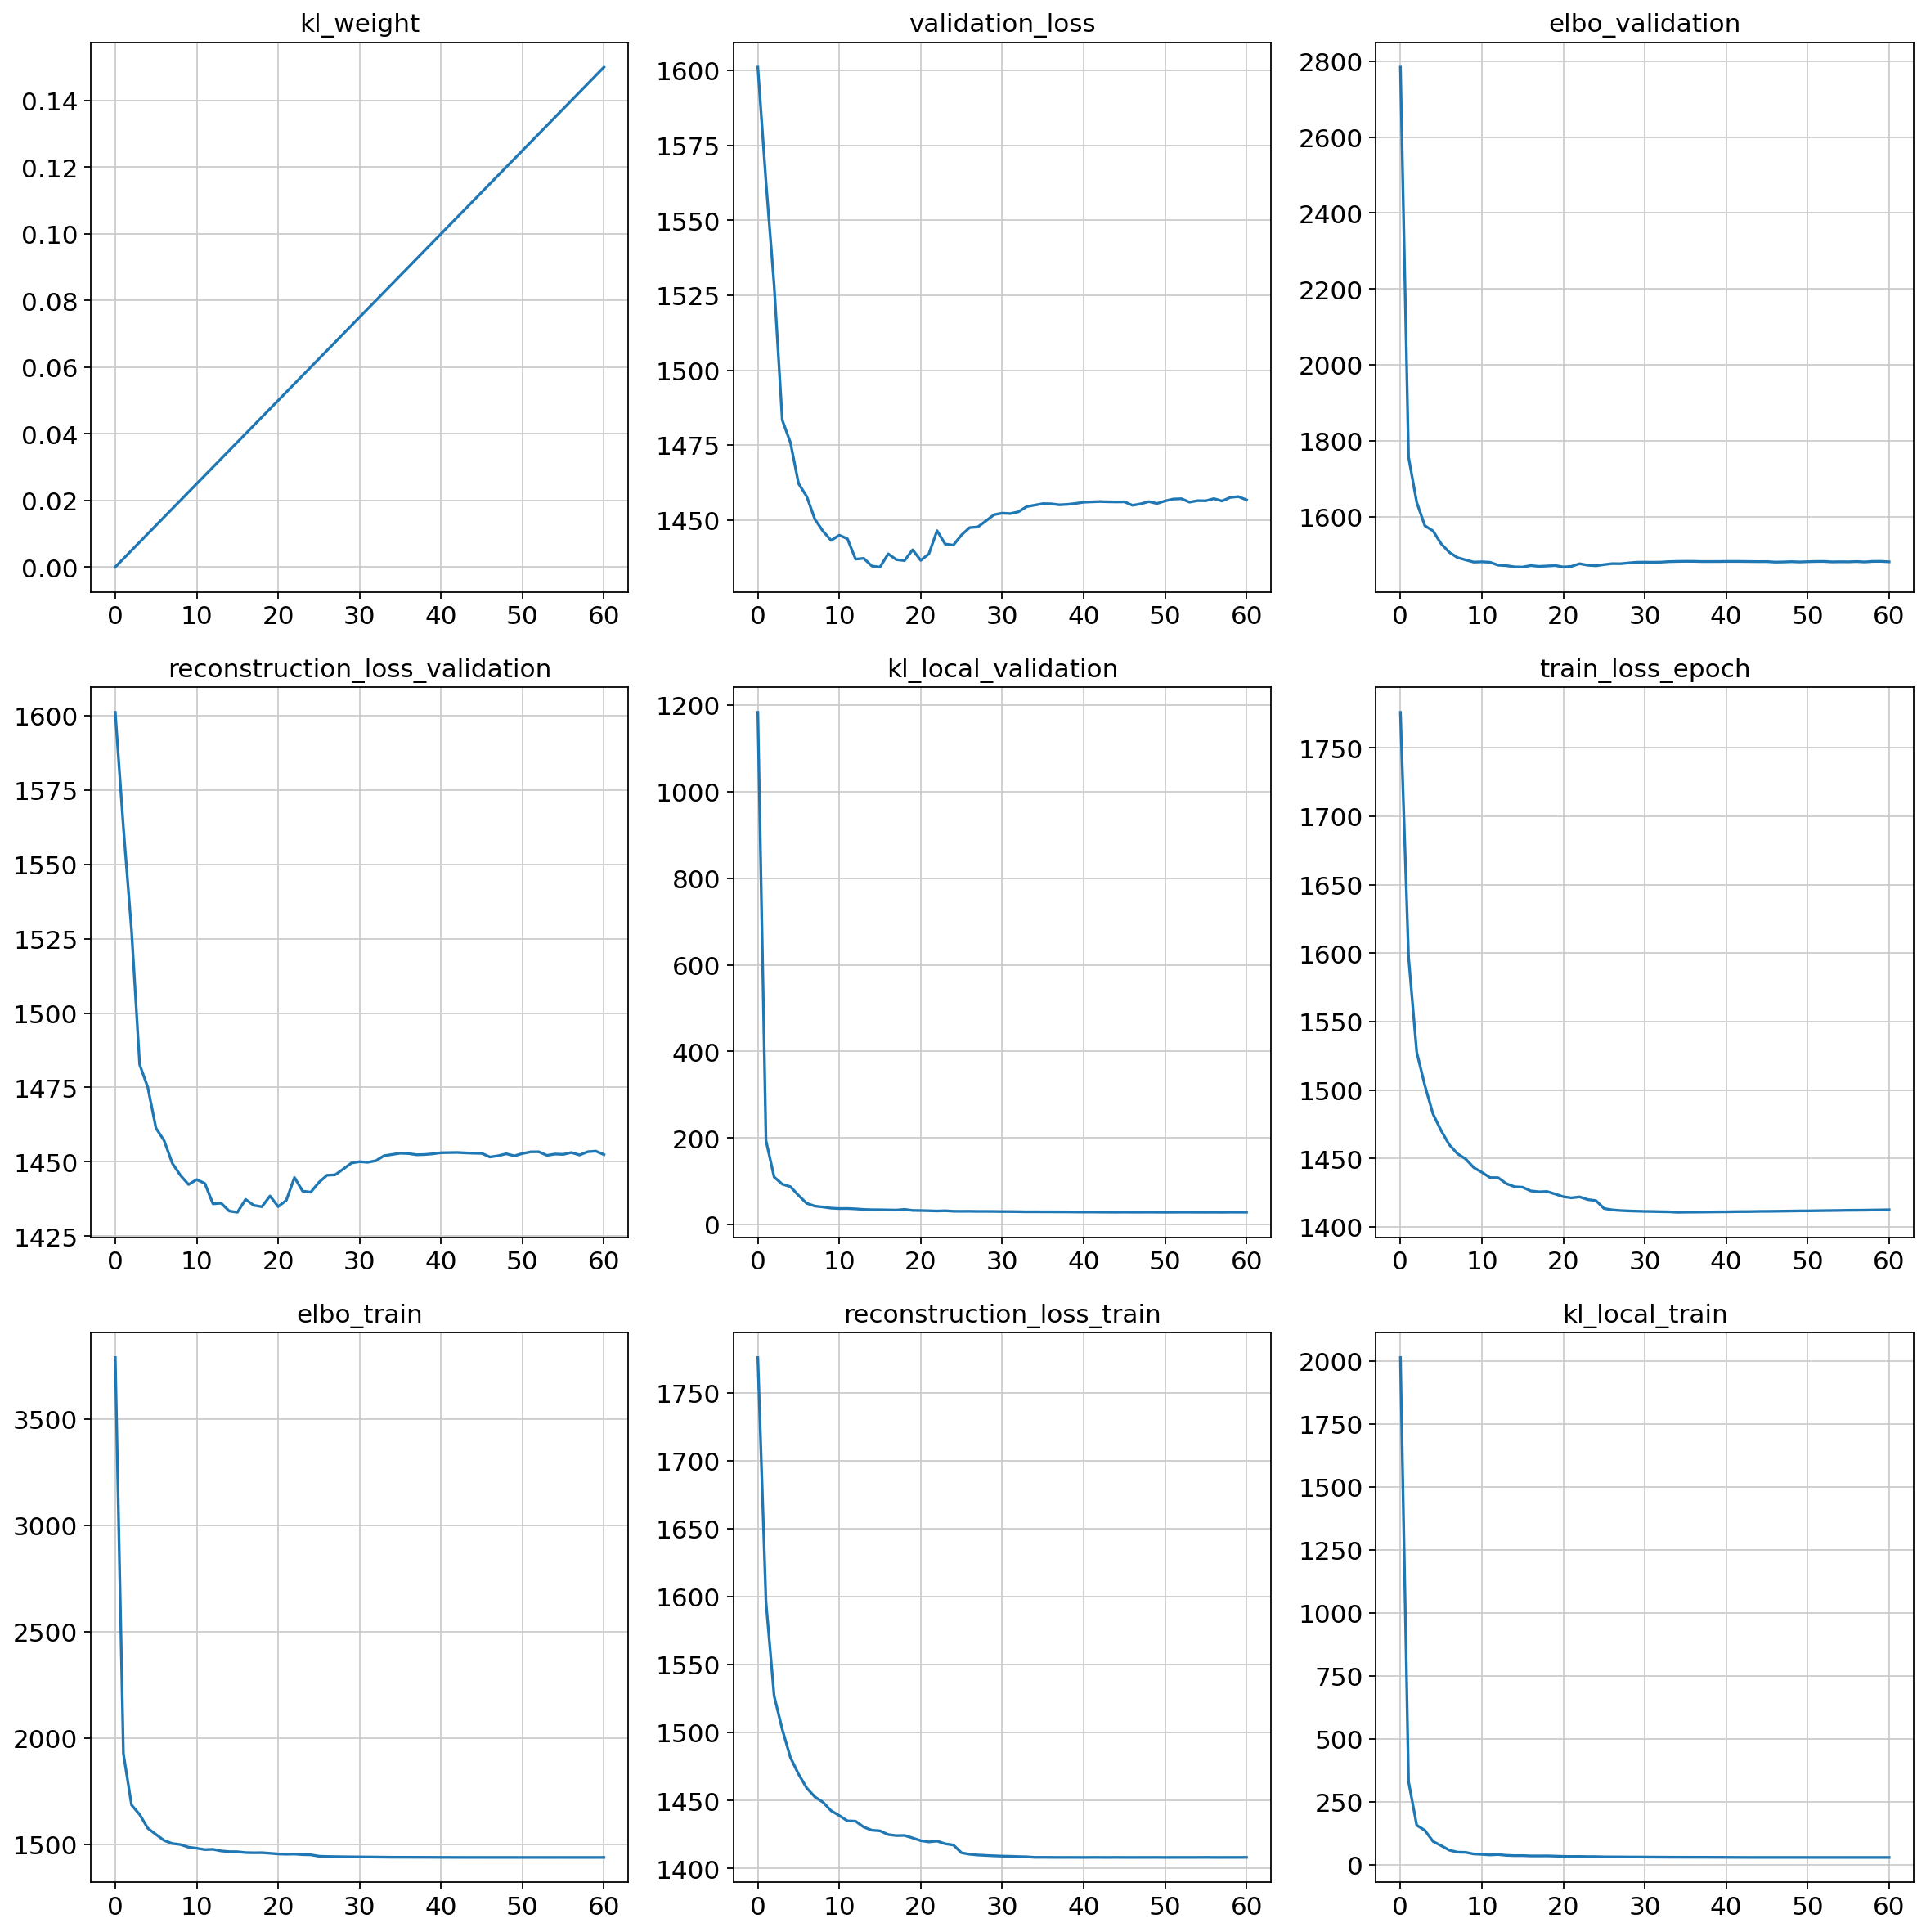

In [13]:
history_keys = [
    'kl_weight', 'validation_loss', 'elbo_validation', 
    'reconstruction_loss_validation', 'kl_local_validation', 
    'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 
    'kl_local_train'
]

# Assuming scanvae.history contains the training history
plot_training_history(vae.history, history_keys)

#### SCANVI

In [14]:
scanvae = sca.models.SCANVI.from_scvi_model(vae, unlabeled_category = "Unknown")

In [ ]:
early_stopping_kwargs = {
    "early_stopping_monitor": "elbo",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.01,
}
# # This very importanto for actual covnergence... we have seen we tend to hit local minima and this helps i navoiding but only once...  a peridic approach would ve good
plan_kwargs= {
    # "weight_decay": 0.0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 8,
    "lr_factor": 0.1,
}

scanvae.train(max_epochs=300, early_stopping=early_stopping_kwargs, plan_kwargs=plan_kwargs, batch_size=128)

INFO     Training for 300 epochs.                                                                                  


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 45/300:  15%|██████████████▏                                                                                  | 44/300 [4:58:53<29:46:10, 418.63s/it, v_num=1, train_loss_step=718, train_loss_epoch=1.41e+3]

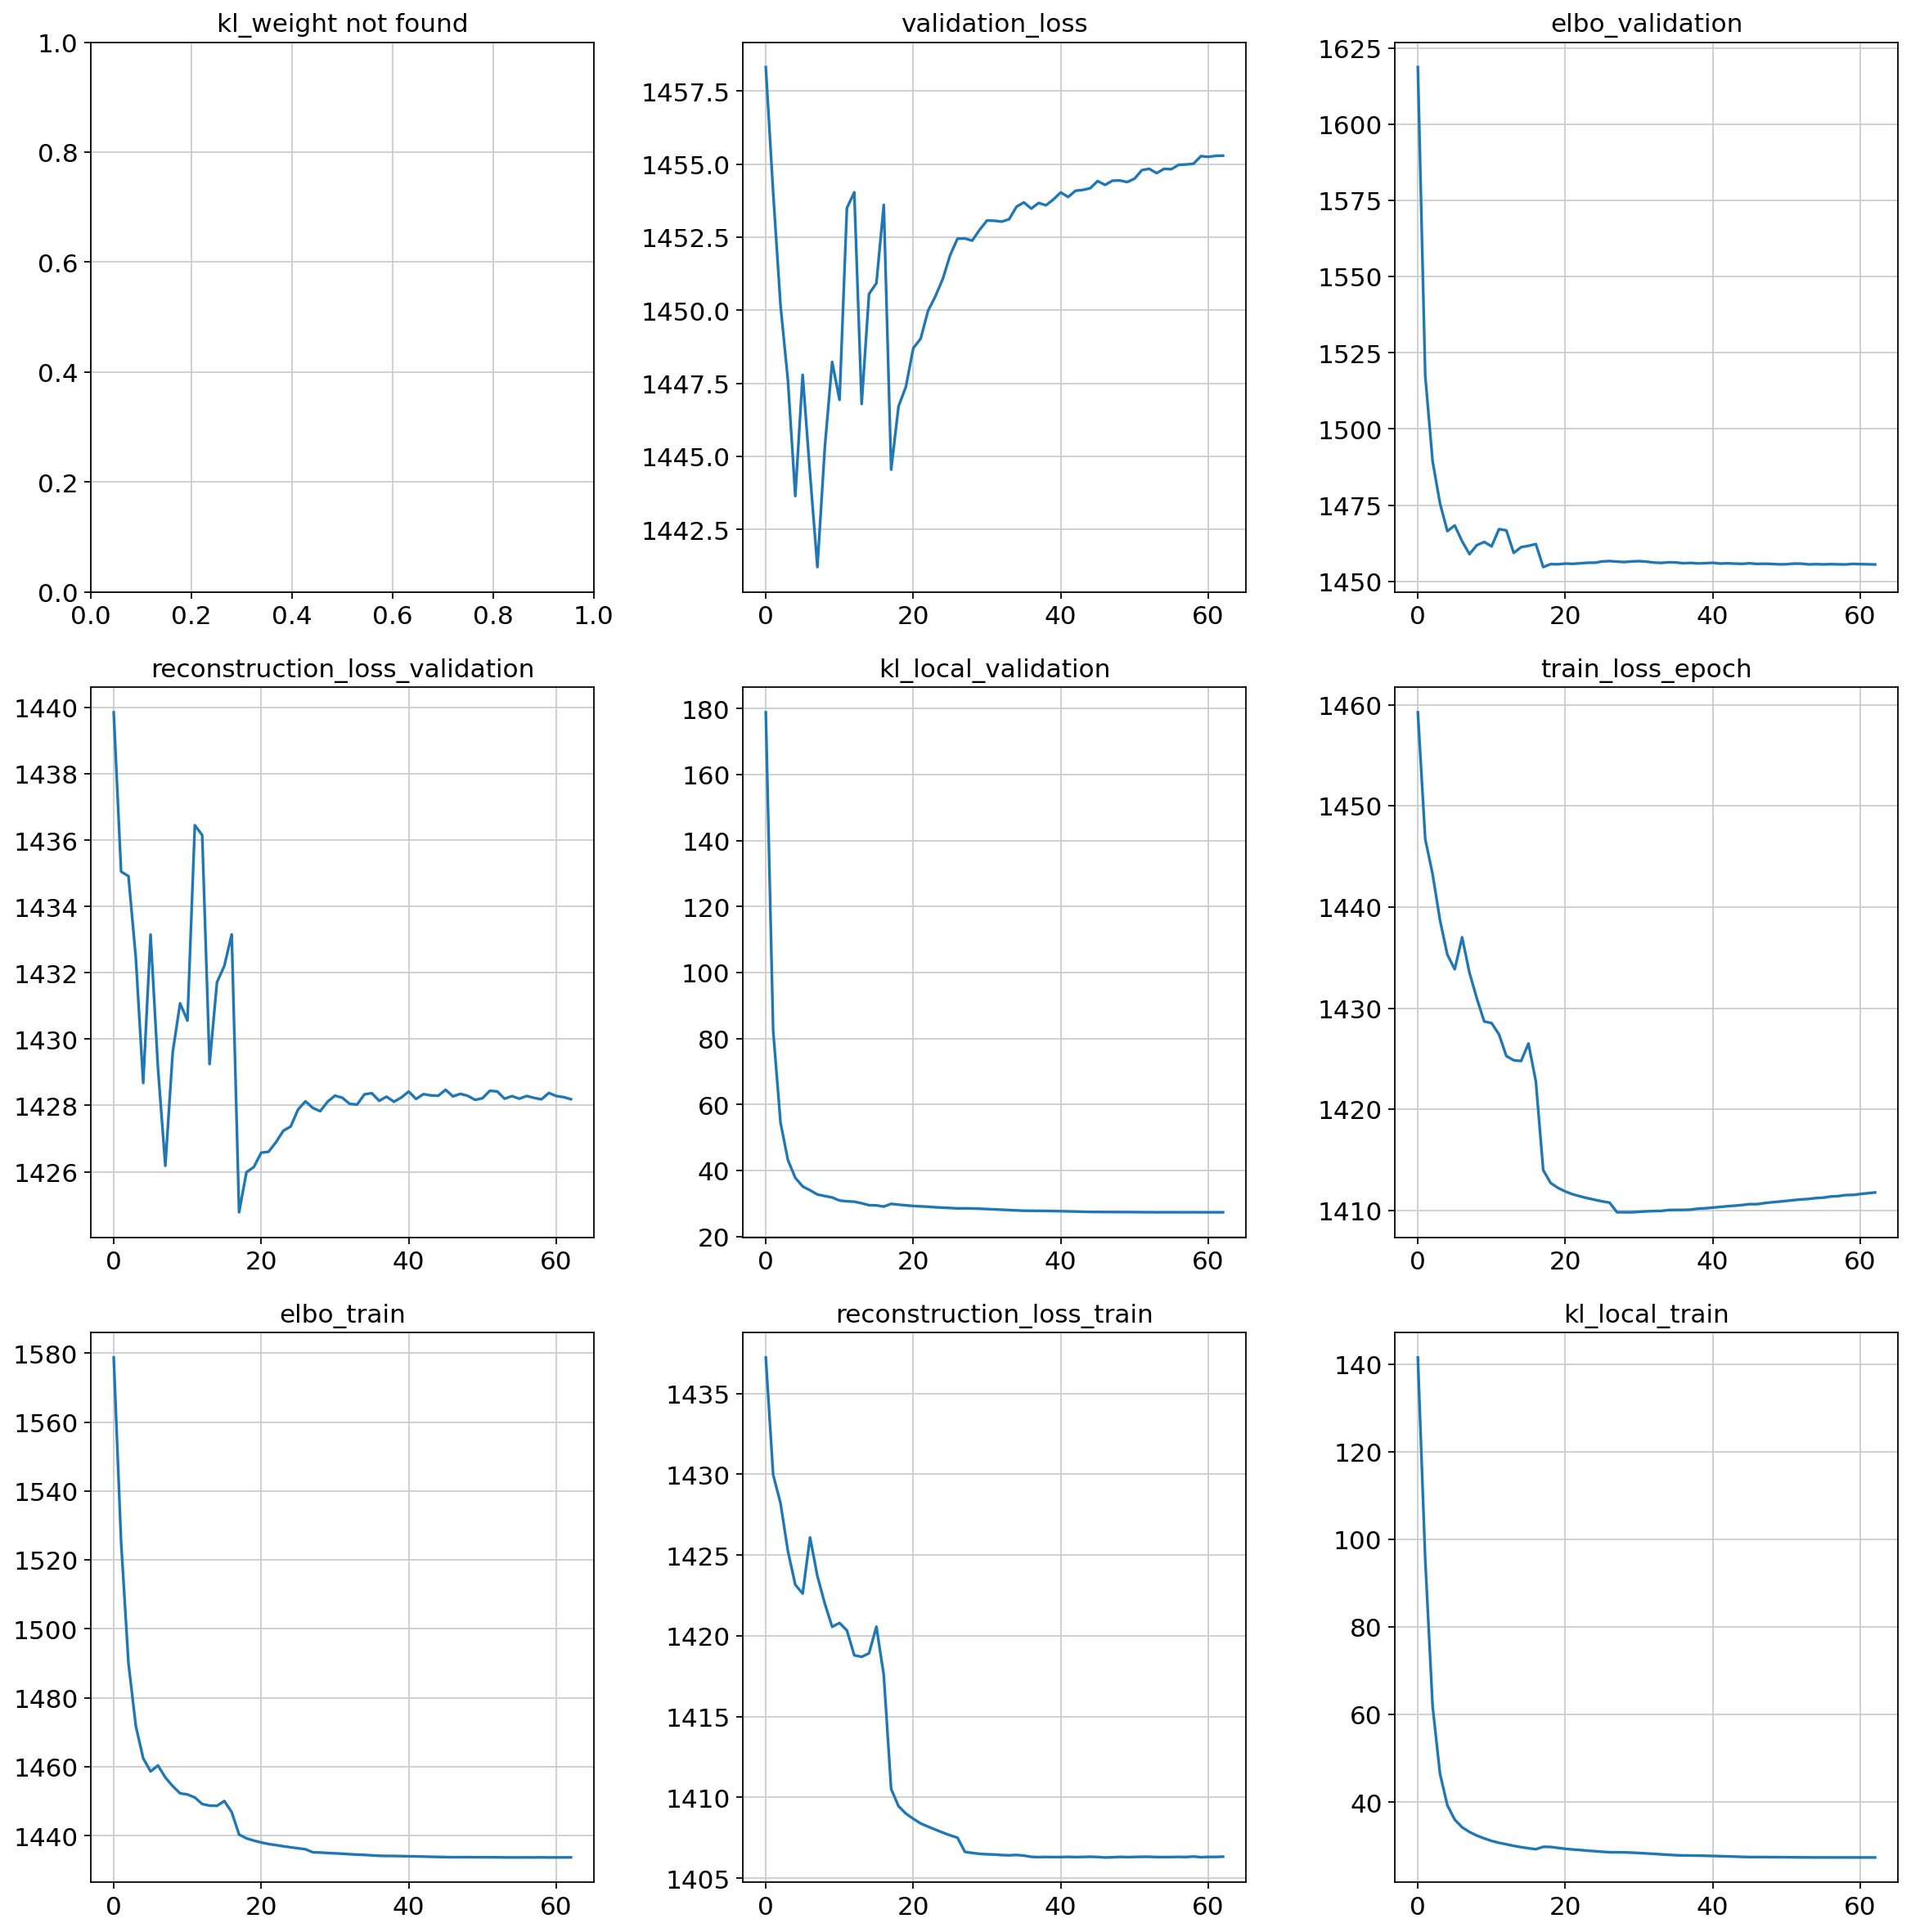

In [43]:
history_keys = [
    'kl_weight', 'validation_loss', 'elbo_validation', 
    'reconstruction_loss_validation', 'kl_local_validation', 
    'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 
    'kl_local_train'
]

# Assuming scanvae.history contains the training history
plot_training_history(scanvae.history, history_keys)

In [ ]:
reference_latent = sc.AnnData(scanvae.get_latent_representation())
reference_latent.obs["cell_type"] = source_adata.obs[cell_type_key].tolist()
reference_latent.obs["batch"] = source_adata.obs[condition_key].tolist()

In [44]:
reference_latent.obs['predictions'] = scanvae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.cell_type)))

Acc: 0.9886398068717496


In [41]:
ref_path = '/root/datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_scanvi_tumor_model_b128_lay4_h1024_raydefault/'
scanvae.save(ref_path, overwrite=True)
# scanvae = sca.models.SCANVI.load(ref_path, source_adata)

INFO     File                                                                                                      
         /root/datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_scanvi_tumor_model_b128_lay4_h1024
         _raydefault/model.pt already downloaded                                                                   


/usr/local/lib/python3.11/site-packages/scvi/model/base/_save_load.py:71: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=map_locat

#### SCANVI 2nd run

In [ ]:
scanvae.train(max_epochs=300, early_stopping=early_stopping_kwargs, plan_kwargs=plan_kwargs, batch_size=128)

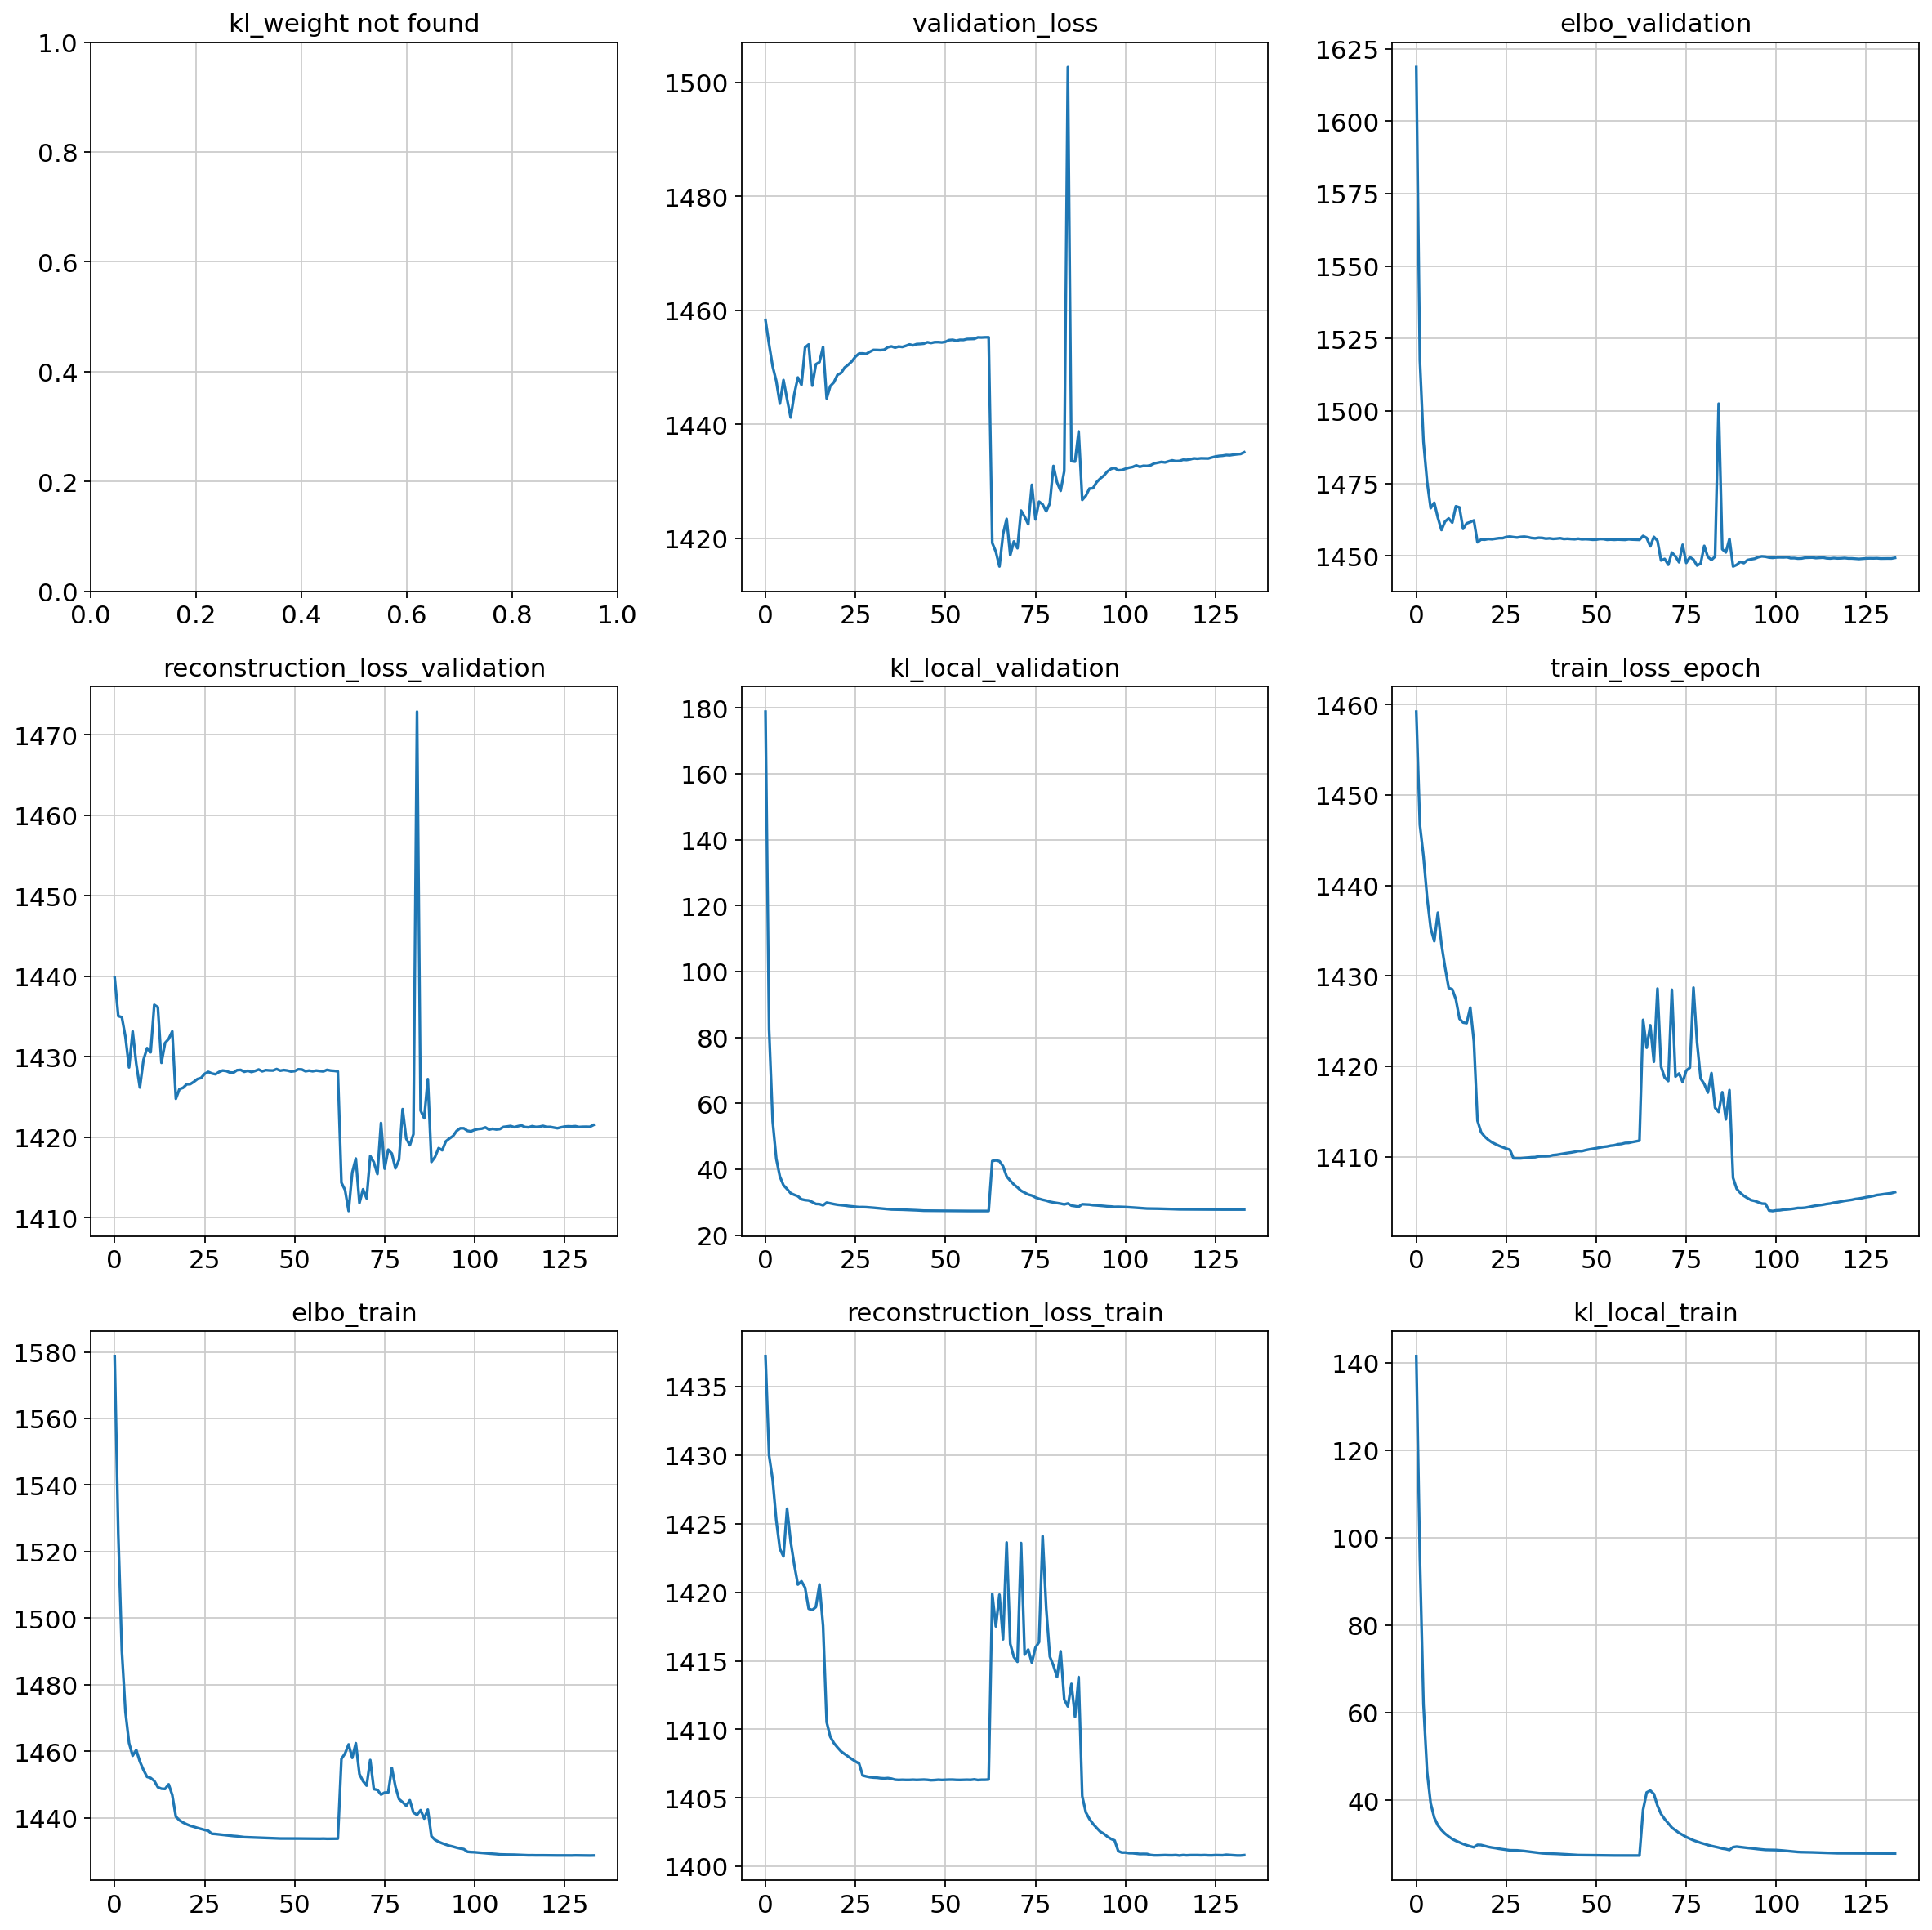

In [45]:
history_keys = [
    'kl_weight', 'validation_loss', 'elbo_validation', 
    'reconstruction_loss_validation', 'kl_local_validation', 
    'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 
    'kl_local_train'
]

# Assuming scanvae.history contains the training history
plot_training_history(scanvae.history, history_keys)

In [ ]:
reference_latent = sc.AnnData(scanvae.get_latent_representation())
reference_latent.obs["cell_type"] = source_adata.obs[cell_type_key].tolist()
reference_latent.obs["batch"] = source_adata.obs[condition_key].tolist()

In [35]:
# reference_latent.obs['predictions'] = scanvae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.cell_type)))

Acc: 0.9957455157785979


**WuhuuuuuuuuuuuU!**

In [51]:
! ls -alh /root/datos/maestria/netopaas/lung_scRNA/LUCA_model/

total 9.4G
drwxr-xr-x 22 root  root   23 Aug 22 07:56 .
drwxrwxr-x 13  1004  1004  16 Jun 21 03:09 ..
drwxr-xr-x  9 root  root    9 Aug 22 00:46 RayTuner
drwxr-xr-x  2 root  root    3 Jul 30 01:03 Zuani
-rw-r--r--  1 40082 50000 16G Aug 29  2022 full_atlas_hvg_integrated_scvi_integrated_scanvi.h5ad
drwxrws---  2 40082 60029   3 Aug 29  2022 hvg_integrated_scvi_scanvi_major_model
drwxr-xr-x  2 root  root    2 Jul 23 18:34 hvg_integrated_scvi_scanvi_tumor_model
drwxr-xr-x  2 root  root    4 Aug  2 21:36 hvg_integrated_scvi_scanvi_tumor_model_3layers
drwxr-xr-x  2 root  root    3 Aug  6 16:23 hvg_integrated_scvi_scanvi_tumor_model_anvi3layers
drwxr-xr-x  2 root  root    3 Aug 21 23:55 hvg_integrated_scvi_scanvi_tumor_model_b128_lay4_h1024_raydefault
drwxr-xr-x  2 root  root    4 Aug 22 13:37 hvg_integrated_scvi_scanvi_tumor_model_b128_lay4_h1024_raydefault_epocs300-300
drwxr-xr-x  2 root  root    3 Aug  5 18:03 hvg_integrated_scvi_scanvi_tumor_model_batch1024
drwxr-xr-x  2 root  root    4

In [55]:
ref_path = '/root/datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_scanvi_tumor_model_b128_lay4_h1024_raydefault_epocs300-300/'
scanvae.save(ref_path, overwrite=True)

In [37]:
# reference_latent.write_h5ad('/root/datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_scanvi_tumor_model_b128_lay4_h1024_raydefault_epocs300-300/ref_latent.h5ad')
reference_latent = sc.read_h5ad('/root/datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_scanvi_tumor_model_b128_lay4_h1024_raydefault_epocs300-300/ref_latent.h5ad')

### b128_lay6_h1024

In [17]:
# elbo_trai is btter for converging and elbo is better for generalization.
# I would suggest, elbo_train for scVi and elbo for scANVI
early_stopping_kwargs = {
    "early_stopping_monitor": "elbo",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.01,
}
# This very importanto for actual covnergence... we have seen we tend to hit local minima and this helps i navoiding but only once...  a peridic approach would ve good
plan_kwargs= {
# "weight_decay": 0.0,
    # "reduce_lr_on_plateau": True,
    # "lr_patience": 8,
    # "lr_factor": 0.1,
}


vae = sca.models.SCVI(
    source_adata,
    n_layers=6,
    n_latent=20,
    n_hidden=1024,
    encode_covariates=True,
    deeply_inject_covariates=False,
    gene_likelihood='nb',  # Nb maybe may have less false postiives, because zinb zeros are complete technical zeroes which are not very realistic
    use_layer_norm="both",
    use_batch_norm="none",
)

In [18]:
# this levaes with litlle epochs and that does not achieve good accuracy
# max_epochs_scvi = np.min([round((20000 / source_adata.n_obs) * 400), 400])
vae.train(max_epochs=400, early_stopping=early_stopping_kwargs, plan_kwargs=plan_kwargs, batch_size=128)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [7:42:37<00:00, 67.61s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.65e+3]

INFO: `Trainer.fit` stopped: `max_epochs=400` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [7:42:37<00:00, 69.39s/it, v_num=1, train_loss_step=1.13e+3, train_loss_epoch=1.65e+3]


In [19]:
ref_path = '/root/datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_tumor_model_b128_lay6_h1024/'
vae.save(ref_path, overwrite=True)

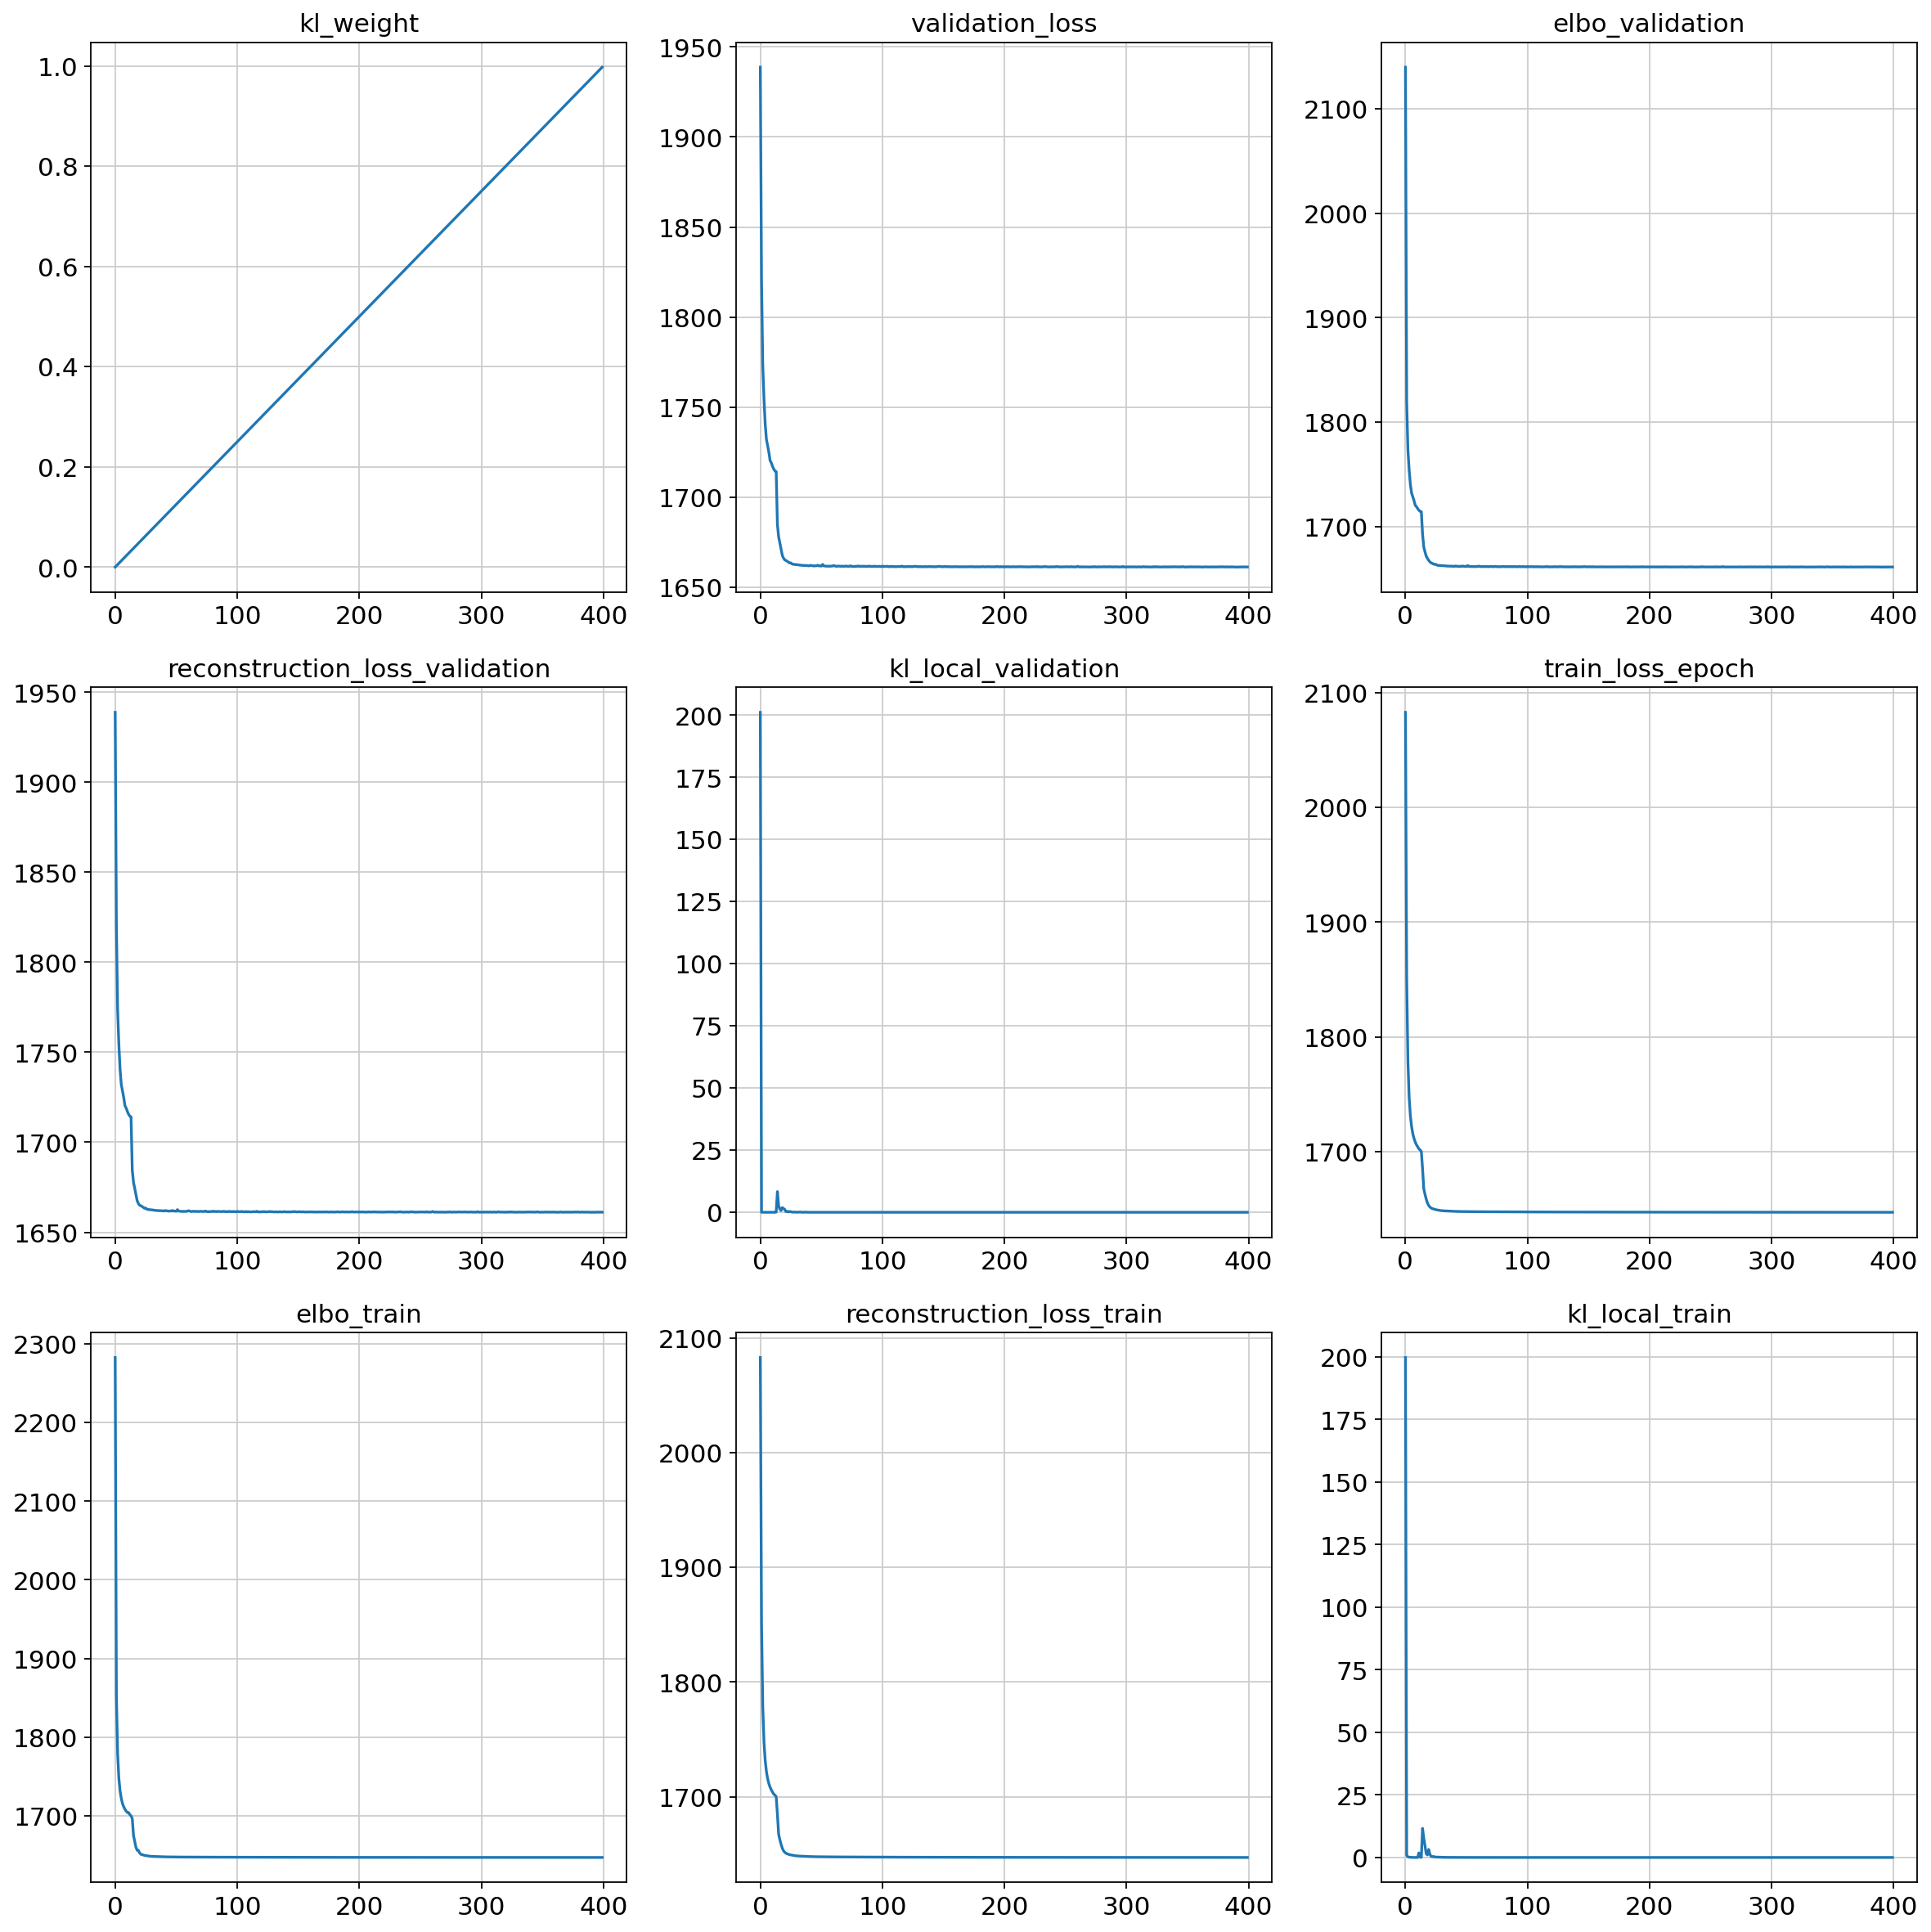

In [20]:
# 128bsize, 400 max, stop 85, 3 layers, 512 hidden
history_keys = [
    'kl_weight', 'validation_loss', 'elbo_validation', 
    'reconstruction_loss_validation', 'kl_local_validation', 
    'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 
    'kl_local_train'
]

# Assuming scanvae.history contains the training history
plot_training_history(vae.history, history_keys)

### b128_lay3_h512

In [16]:
# elbo_trai is btter for converging and elbo is better for generalization.
# I would suggest, elbo_train for scVi and elbo for scANVI
early_stopping_kwargs = {
    "early_stopping_monitor": "elbo",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.01,
}
# This very importanto for actual covnergence... we have seen we tend to hit local minima and this helps i navoiding but only once...  a peridic approach would ve good
plan_kwargs= {"weight_decay": 0.0,
    # "reduce_lr_on_plateau": True,
    # "lr_patience": 8,
    # "lr_factor": 0.1,
}


vae = sca.models.SCVI(
    source_adata,
    n_layers=3,
    n_latent=20,
    n_hidden=512,
    encode_covariates=True,
    deeply_inject_covariates=False,
    gene_likelihood='nb',  # Nb maybe may have less false postiives, because zinb zeros are complete technical zeroes which are not very realistic
    use_layer_norm="both",
    use_batch_norm="none",
)

In [17]:
# this levaes with litlle epochs and that does not achieve good accuracy
# max_epochs_scvi = np.min([round((20000 / source_adata.n_obs) * 400), 400])
vae.train(max_epochs=400, early_stopping=early_stopping_kwargs, plan_kwargs=plan_kwargs, batch_size=128)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 81/400:  20%|███████████████████▏                                                                           | 81/400 [1:06:07<4:20:26, 48.99s/it, v_num=1, train_loss_step=1.47e+3, train_loss_epoch=1.41e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1483.175. Signaling Trainer to stop.


In [18]:
ref_path = '/root/datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_tumor_model_b128_lay3_h512/'
vae.save(ref_path, overwrite=True)

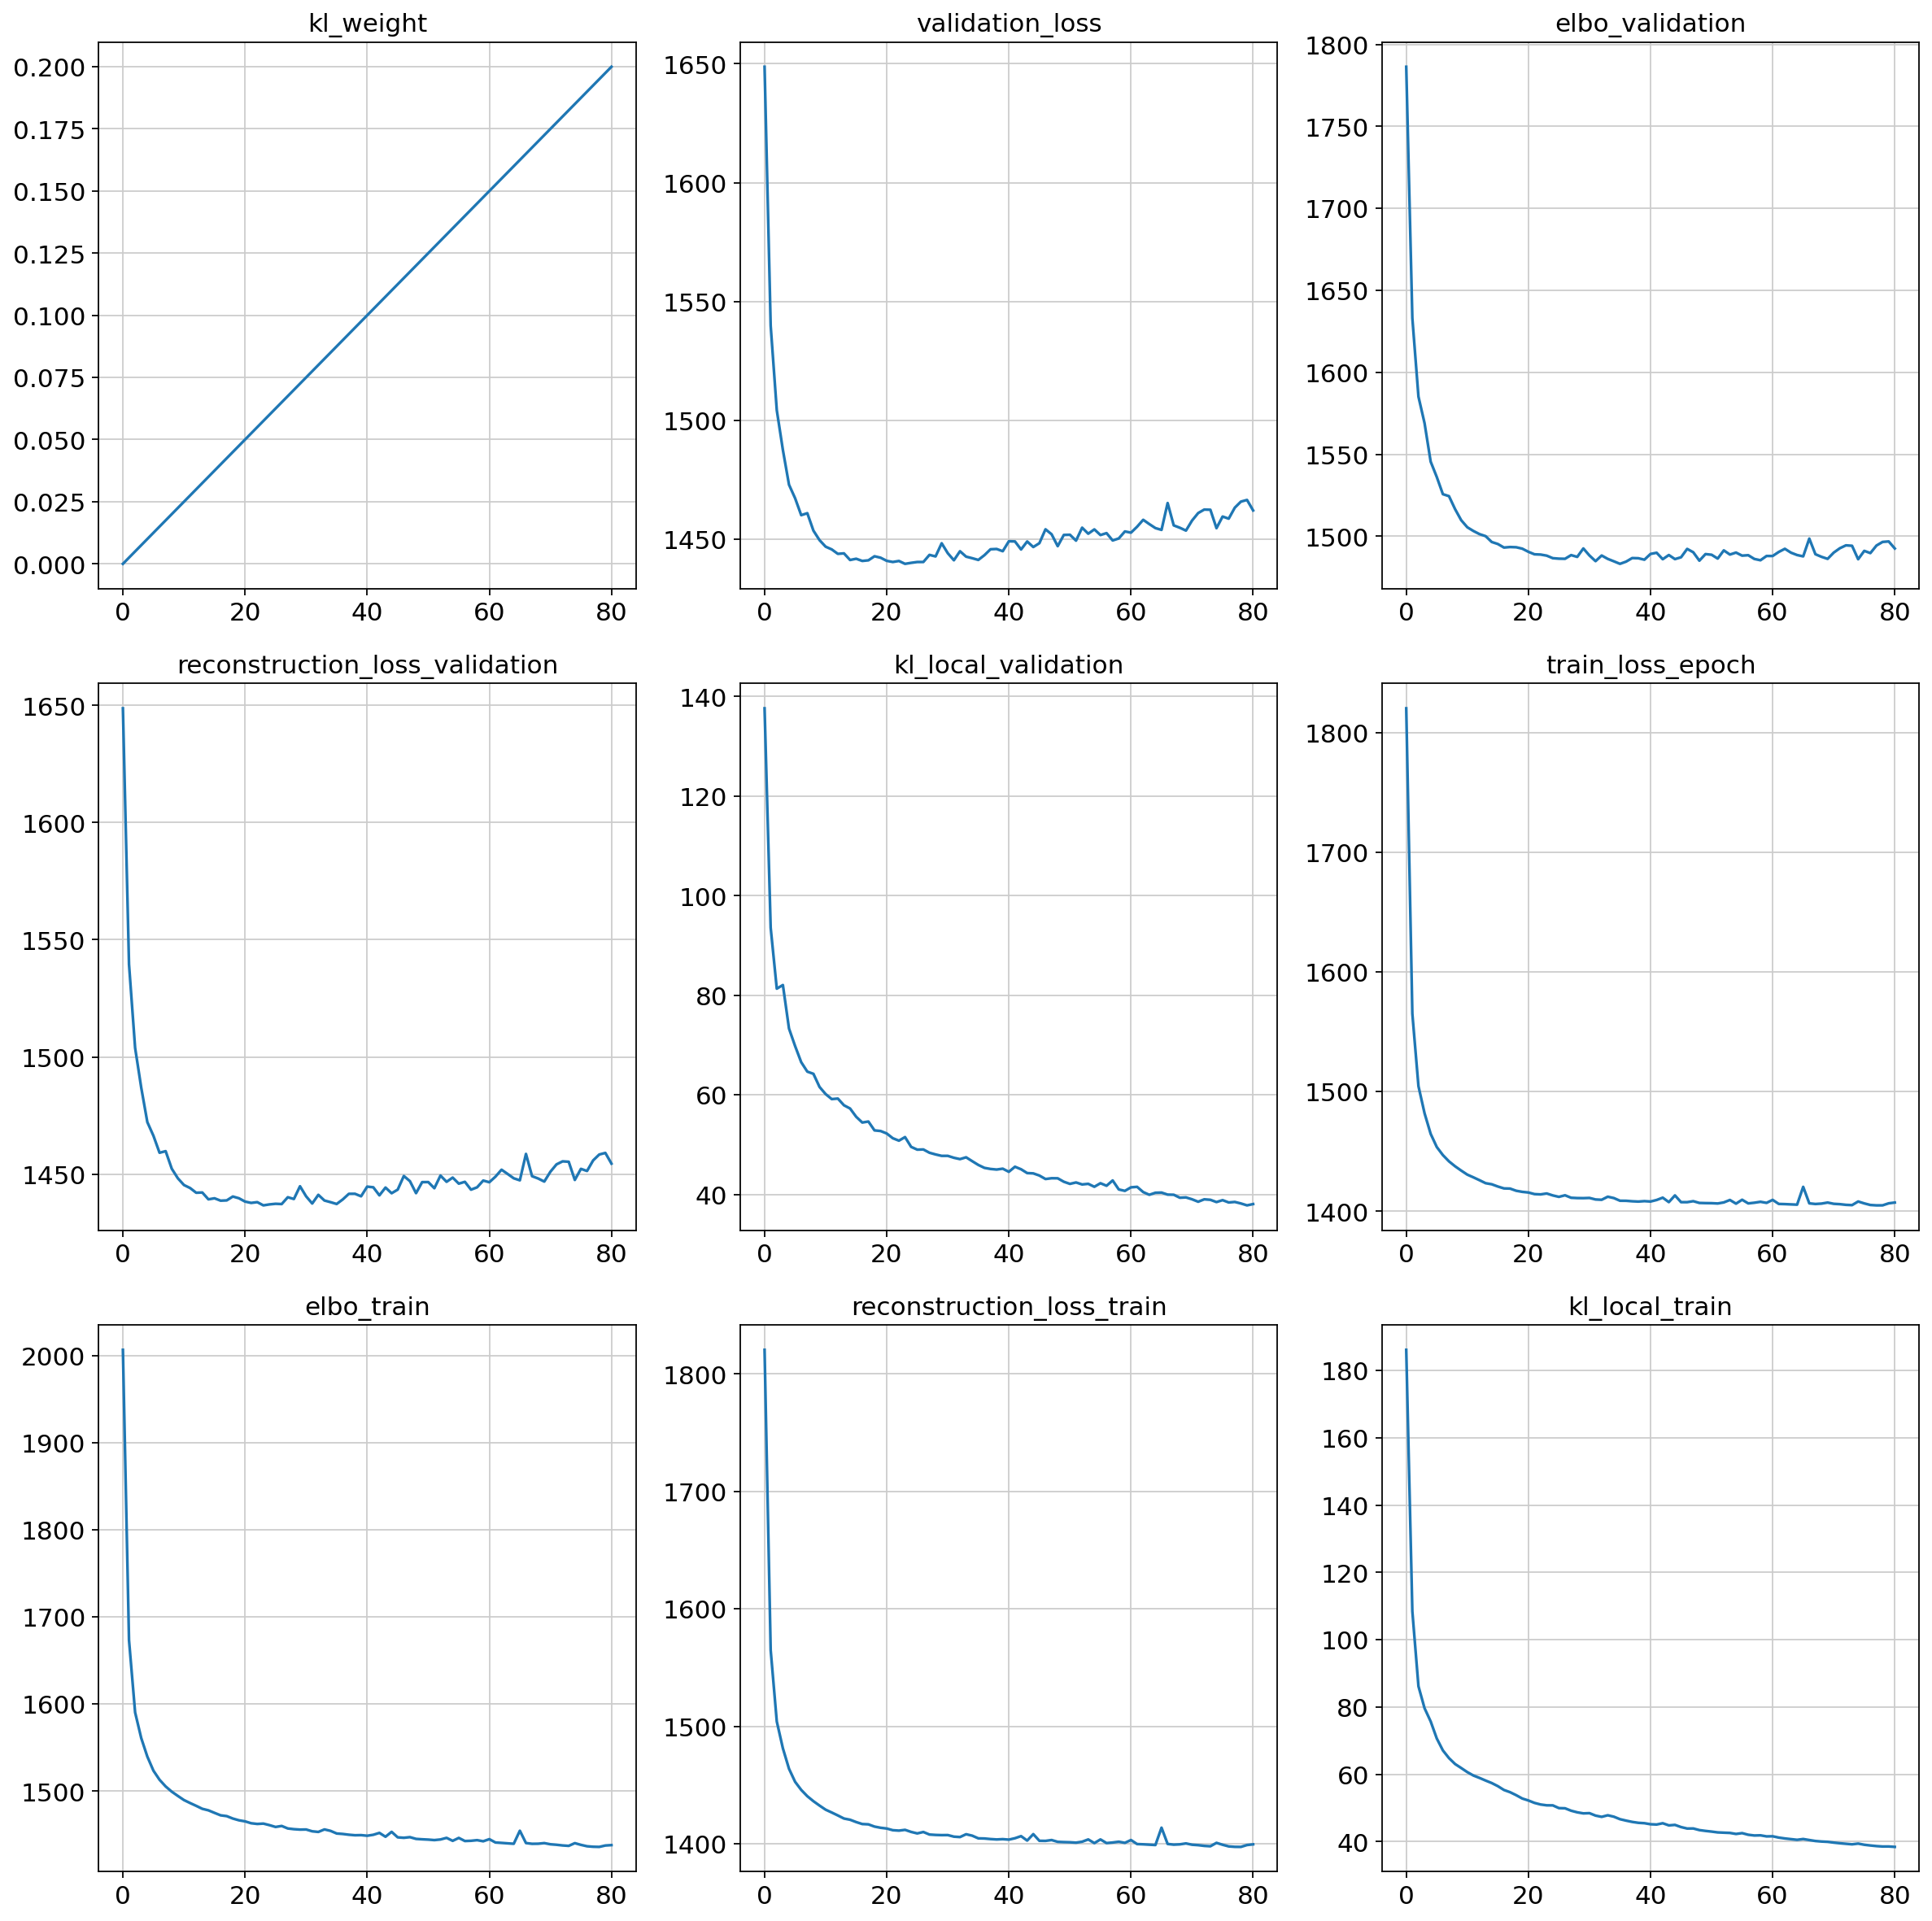

In [28]:
# 128bsize, 400 max, stop 85, 3 layers, 512 hidden
history_keys = [
    'kl_weight', 'validation_loss', 'elbo_validation', 
    'reconstruction_loss_validation', 'kl_local_validation', 
    'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 
    'kl_local_train'
]

# Assuming scanvae.history contains the training history
plot_training_history(vae.history, history_keys)

In [21]:
scanvae = sca.models.SCANVI.from_scvi_model(vae, unlabeled_category = "Unknown")

In [22]:
early_stopping_kwargs = {
    "early_stopping_monitor": "elbo",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.01,
}
# # This very importanto for actual covnergence... we have seen we tend to hit local minima and this helps i navoiding but only once...  a peridic approach would ve good
plan_kwargs= {
    # "weight_decay": 0.0,
#     "reduce_lr_on_plateau": True,
#     "lr_patience": 8,
#     "lr_factor": 0.1,
}


scanvae.train(max_epochs=300, early_stopping=early_stopping_kwargs, plan_kwargs=plan_kwargs, batch_size=128)

INFO     Training for 300 epochs.                                                                                  


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 53/300:  18%|████████████████▊                                                                              | 53/300 [8:53:09<41:24:43, 603.58s/it, v_num=1, train_loss_step=1.1e+3, train_loss_epoch=1.8e+3]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1657.337. Signaling Trainer to stop.


In [23]:
reference_latent = sc.AnnData(scanvae.get_latent_representation())
reference_latent.obs["cell_type"] = source_adata.obs[cell_type_key].tolist()
reference_latent.obs["batch"] = source_adata.obs[condition_key].tolist()

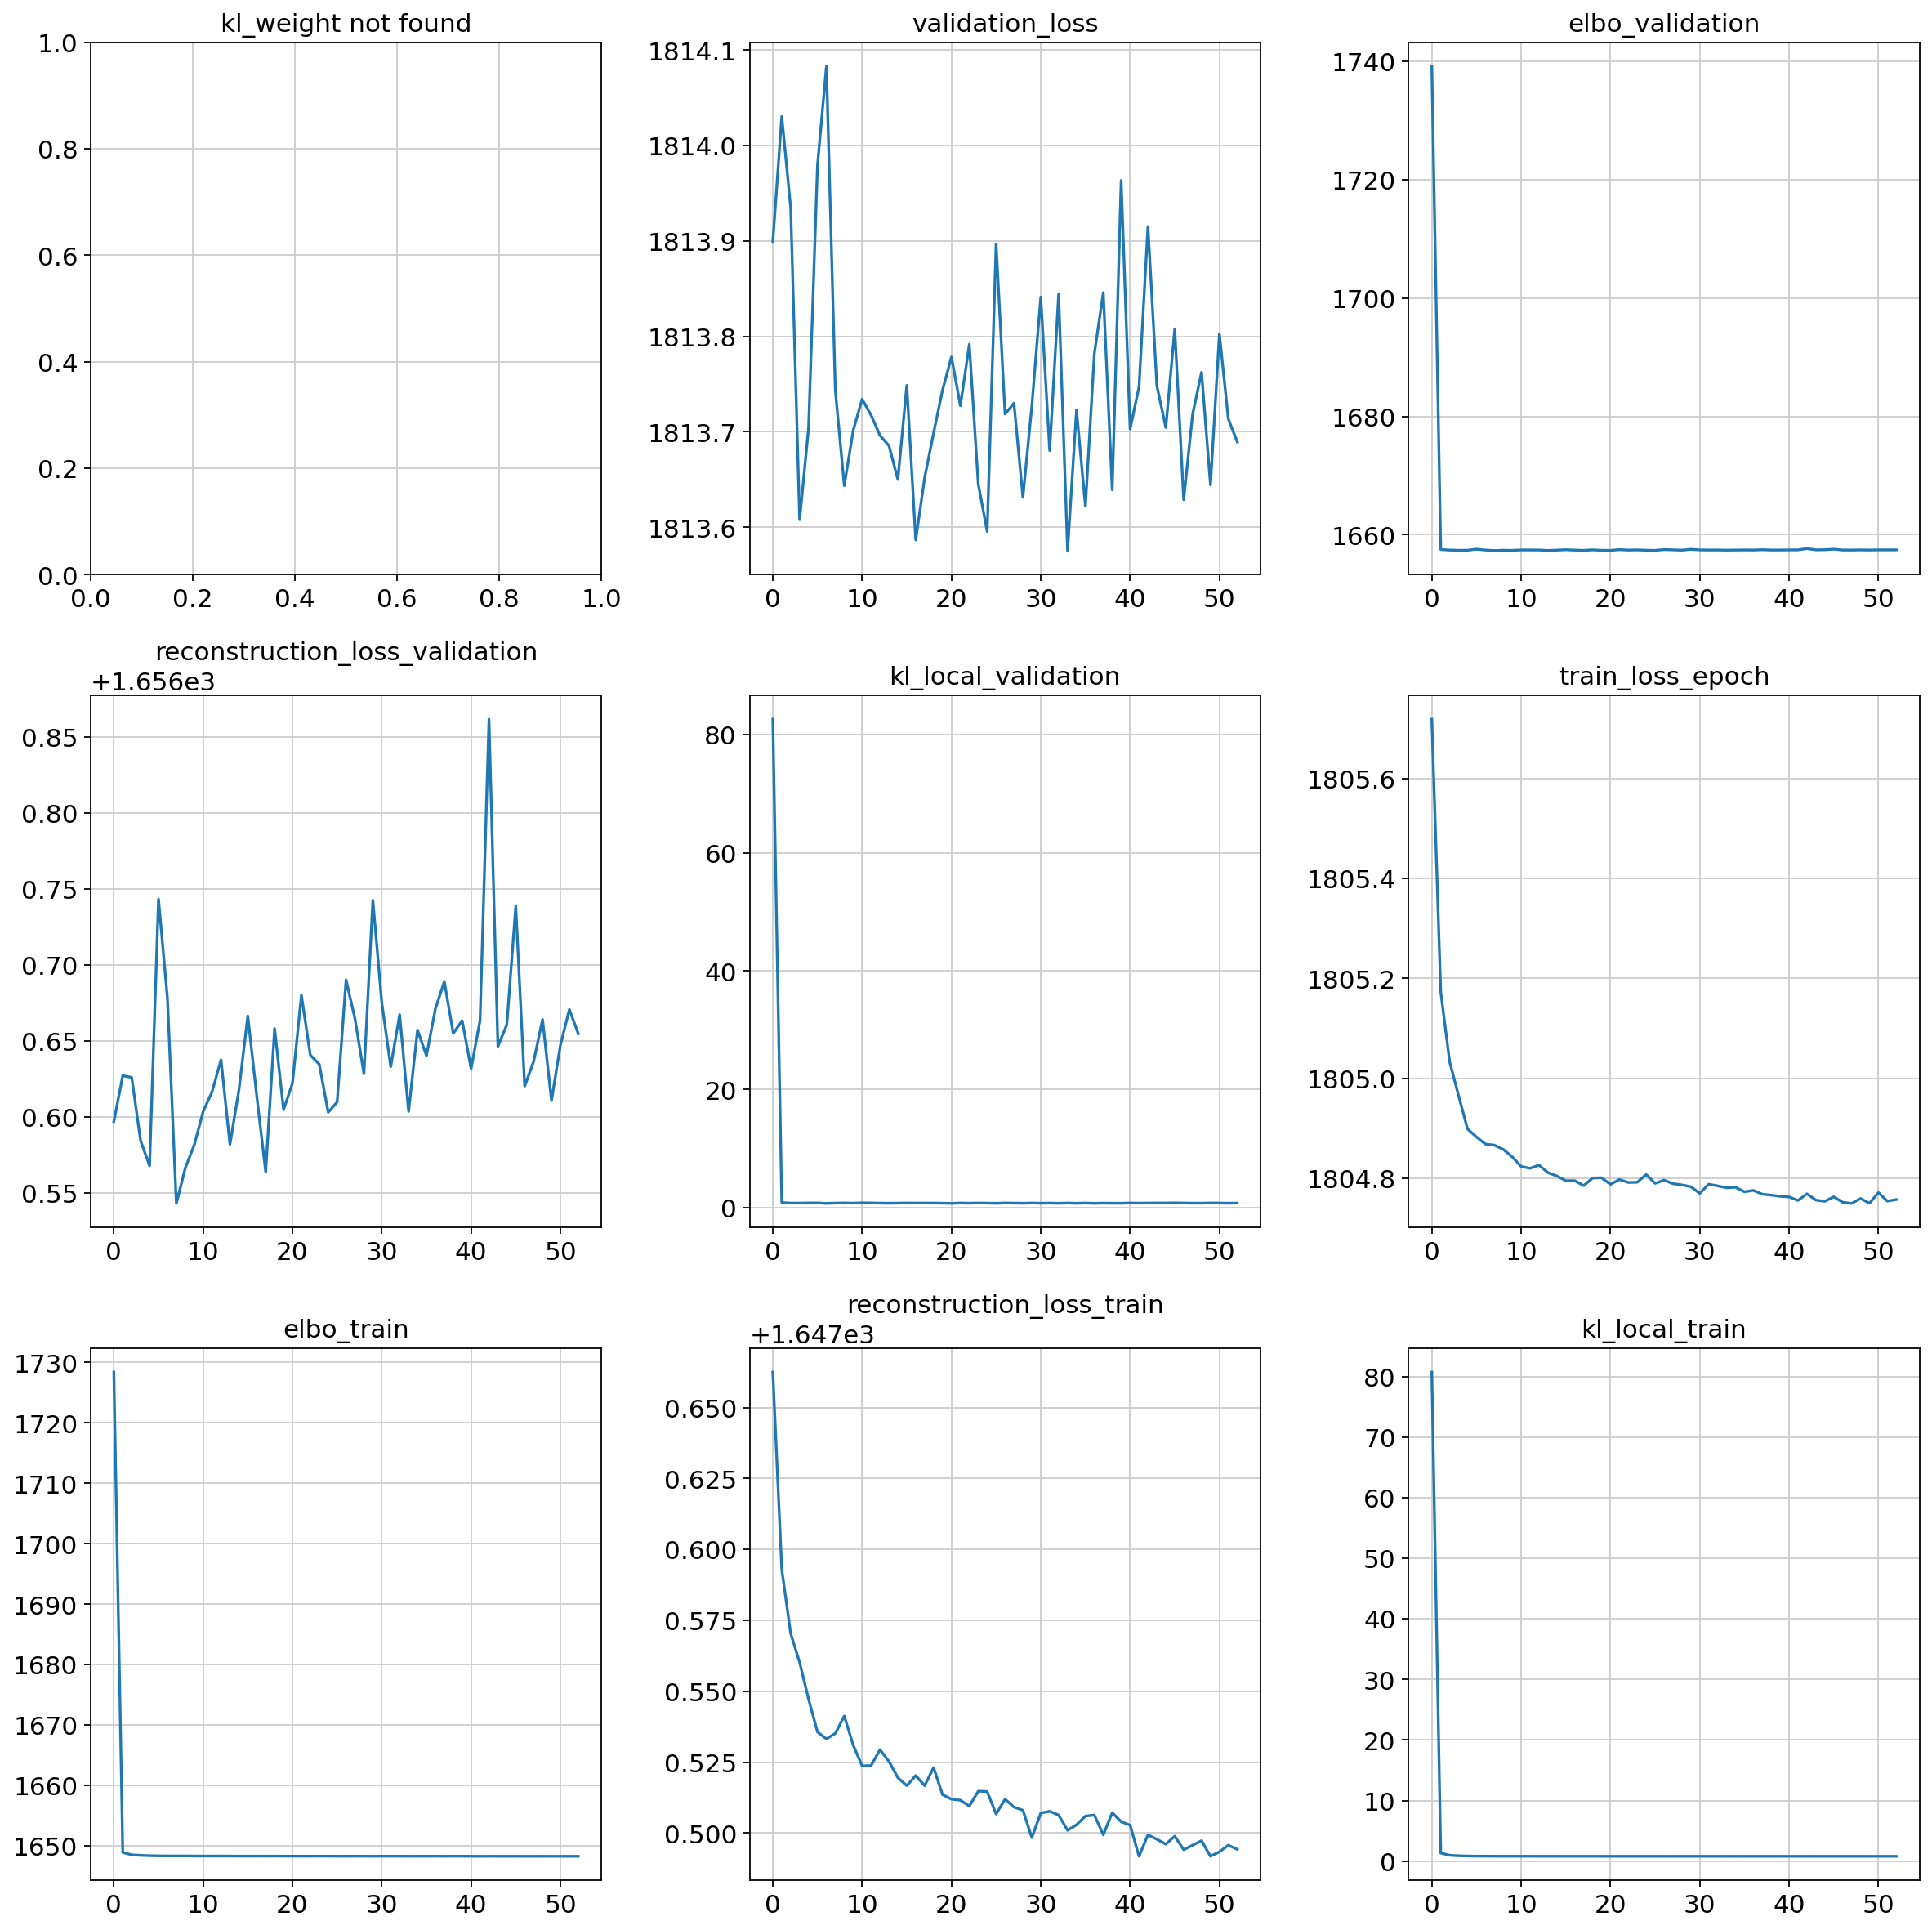

In [25]:
#vae 70 epoch, 128 bsize, hidden512, l 3; scanvae 80 epoch;  
history_keys = [
    'kl_weight', 'validation_loss', 'elbo_validation', 
    'reconstruction_loss_validation', 'kl_local_validation', 
    'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 
    'kl_local_train'
]

# Assuming scanvae.history contains the training history
plot_training_history(scanvae.history, history_keys)

In [24]:

reference_latent.obs['predictions'] = scanvae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.cell_type)))

Acc: 0.13966778761853196


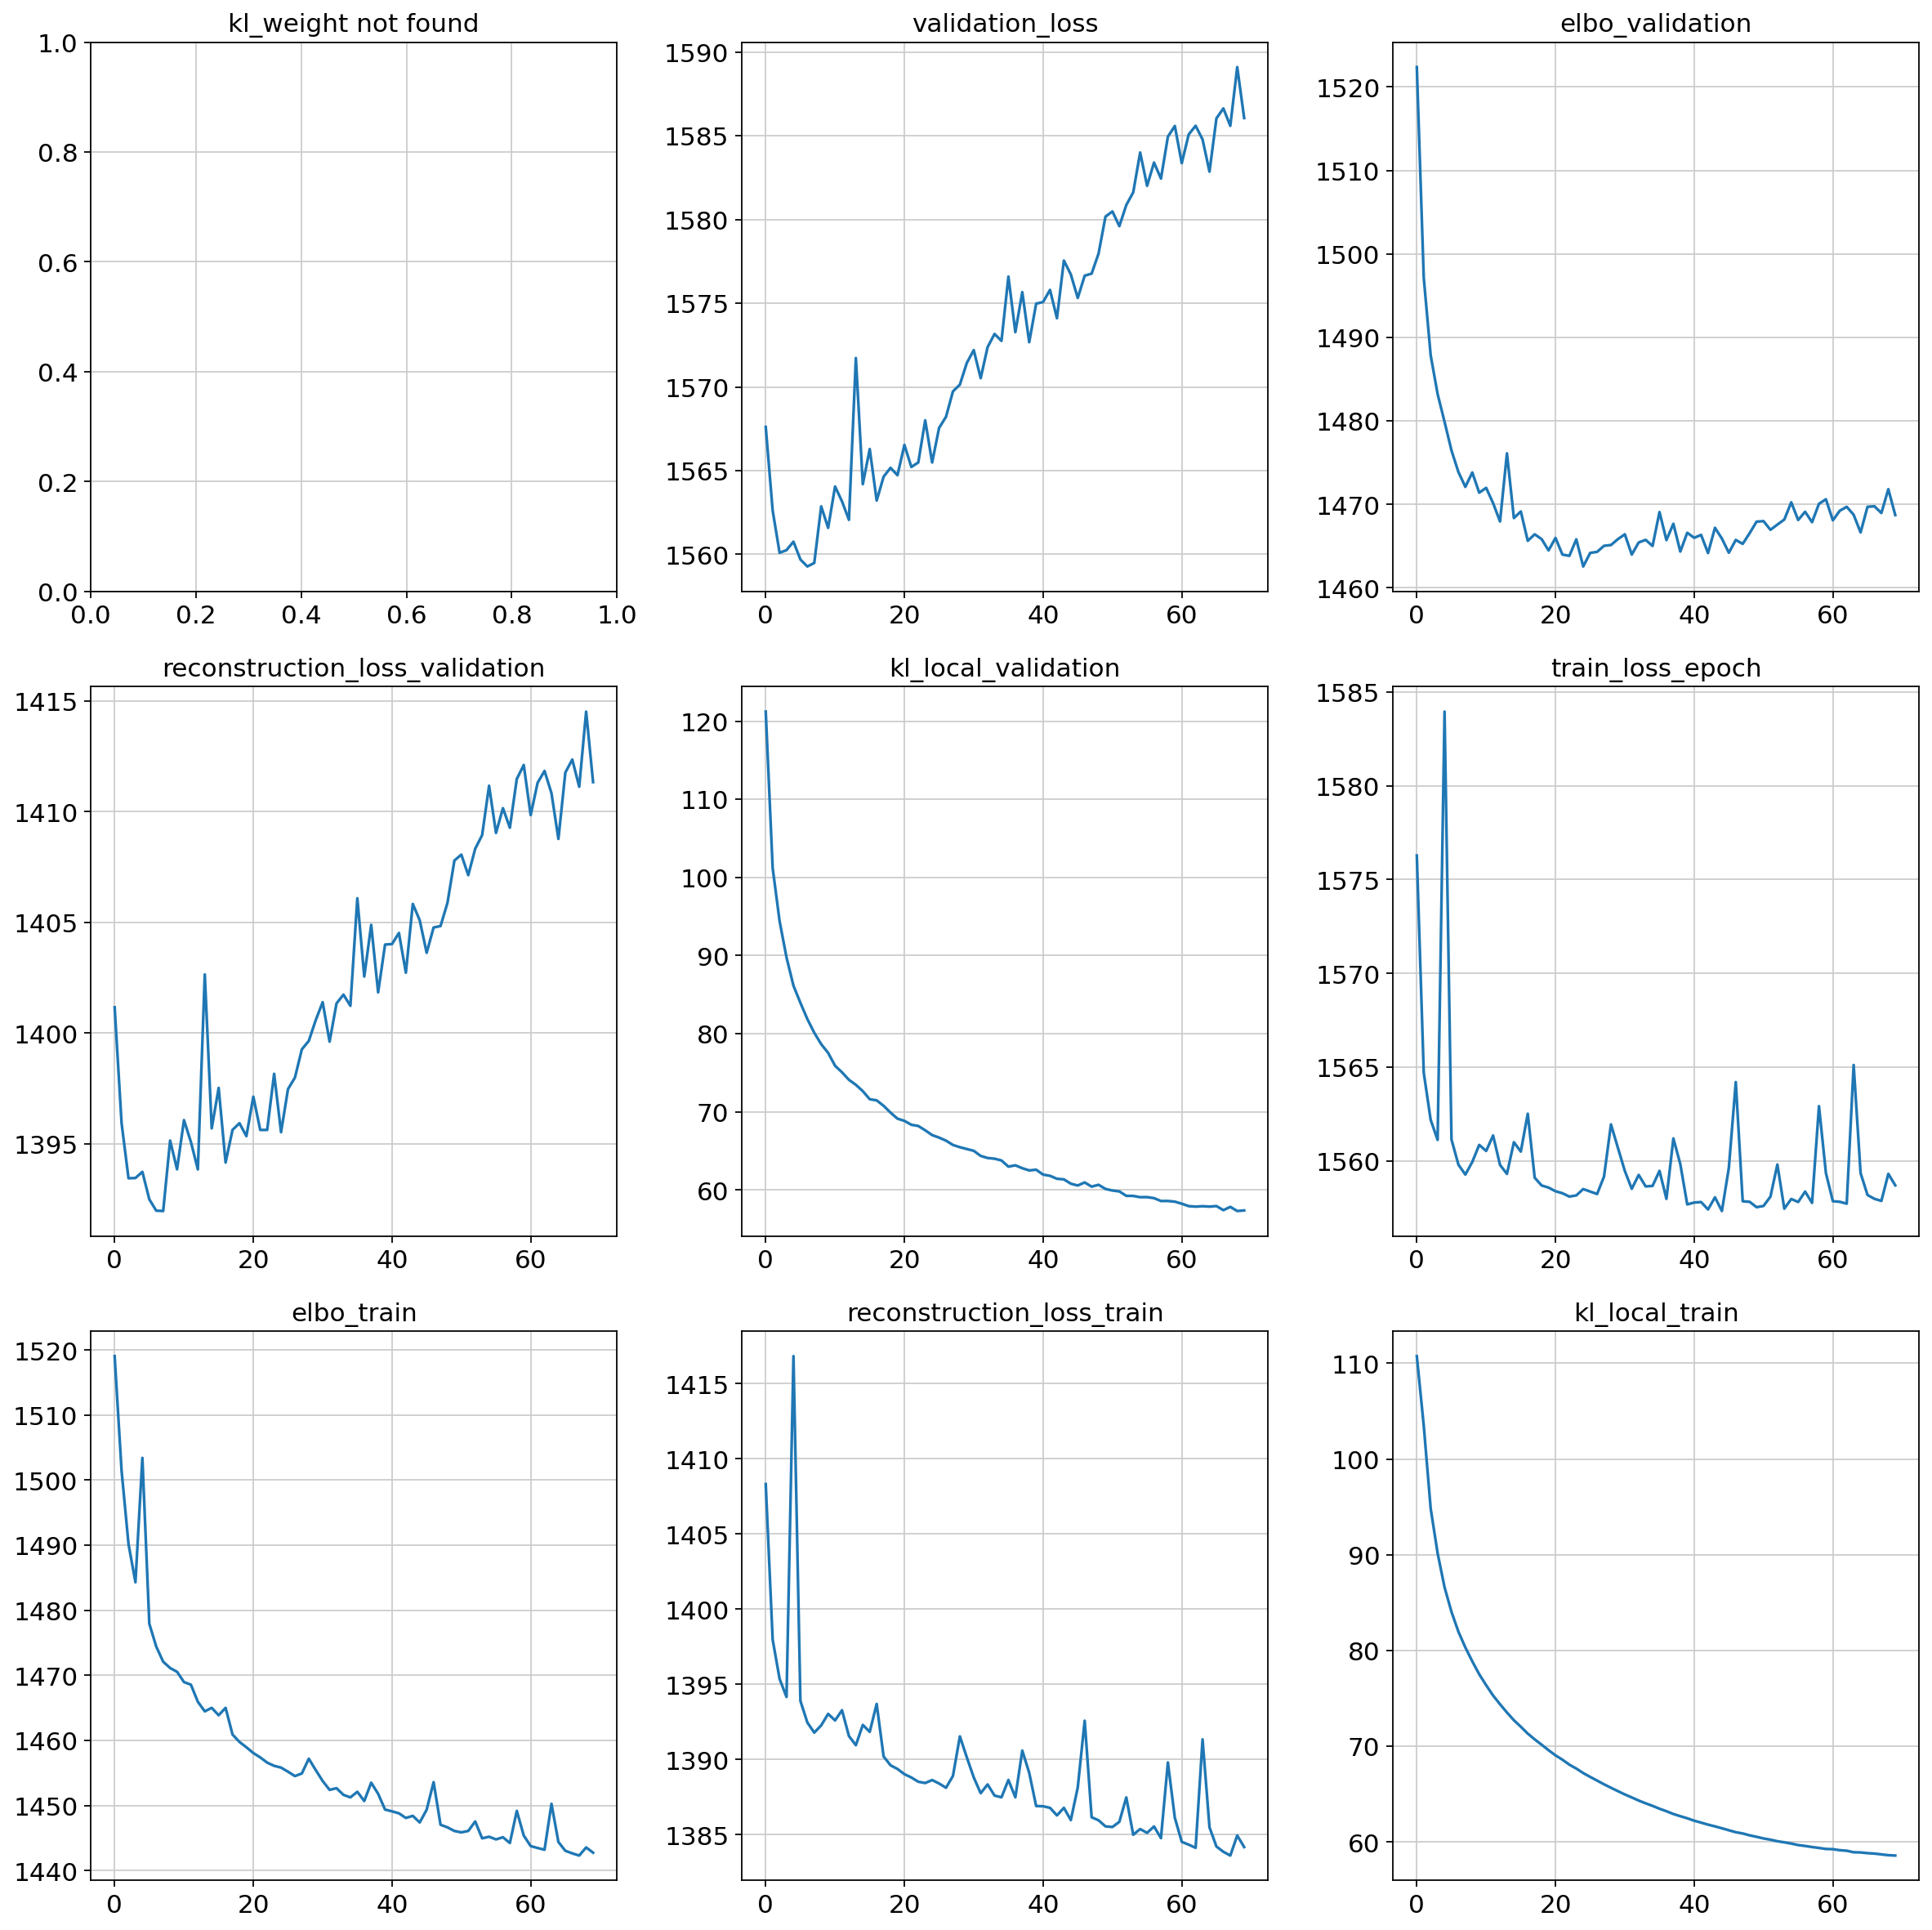

In [35]:
#vae 70 epoch, 128 bsize, hidden512, l 3; scanvae 80 epoch;  weight decay on
history_keys = [
    'kl_weight', 'validation_loss', 'elbo_validation', 
    'reconstruction_loss_validation', 'kl_local_validation', 
    'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 
    'kl_local_train'
]

# Assuming scanvae.history contains the training history
plot_training_history(scanvae.history, history_keys)

In [38]:
#vae 70 epoch, 128 bsize, hidden512, l 3; scanvae 80 epoch;  
reference_latent.obs['predictions'] = scanvae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.cell_type)))

Acc: 0.6790434985619694


In [68]:
ref_path = '/root/datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_scanvi_tumor_model_anvi4layers/'
scanvae.save(ref_path, overwrite=True)

### b1024_lay4_h512

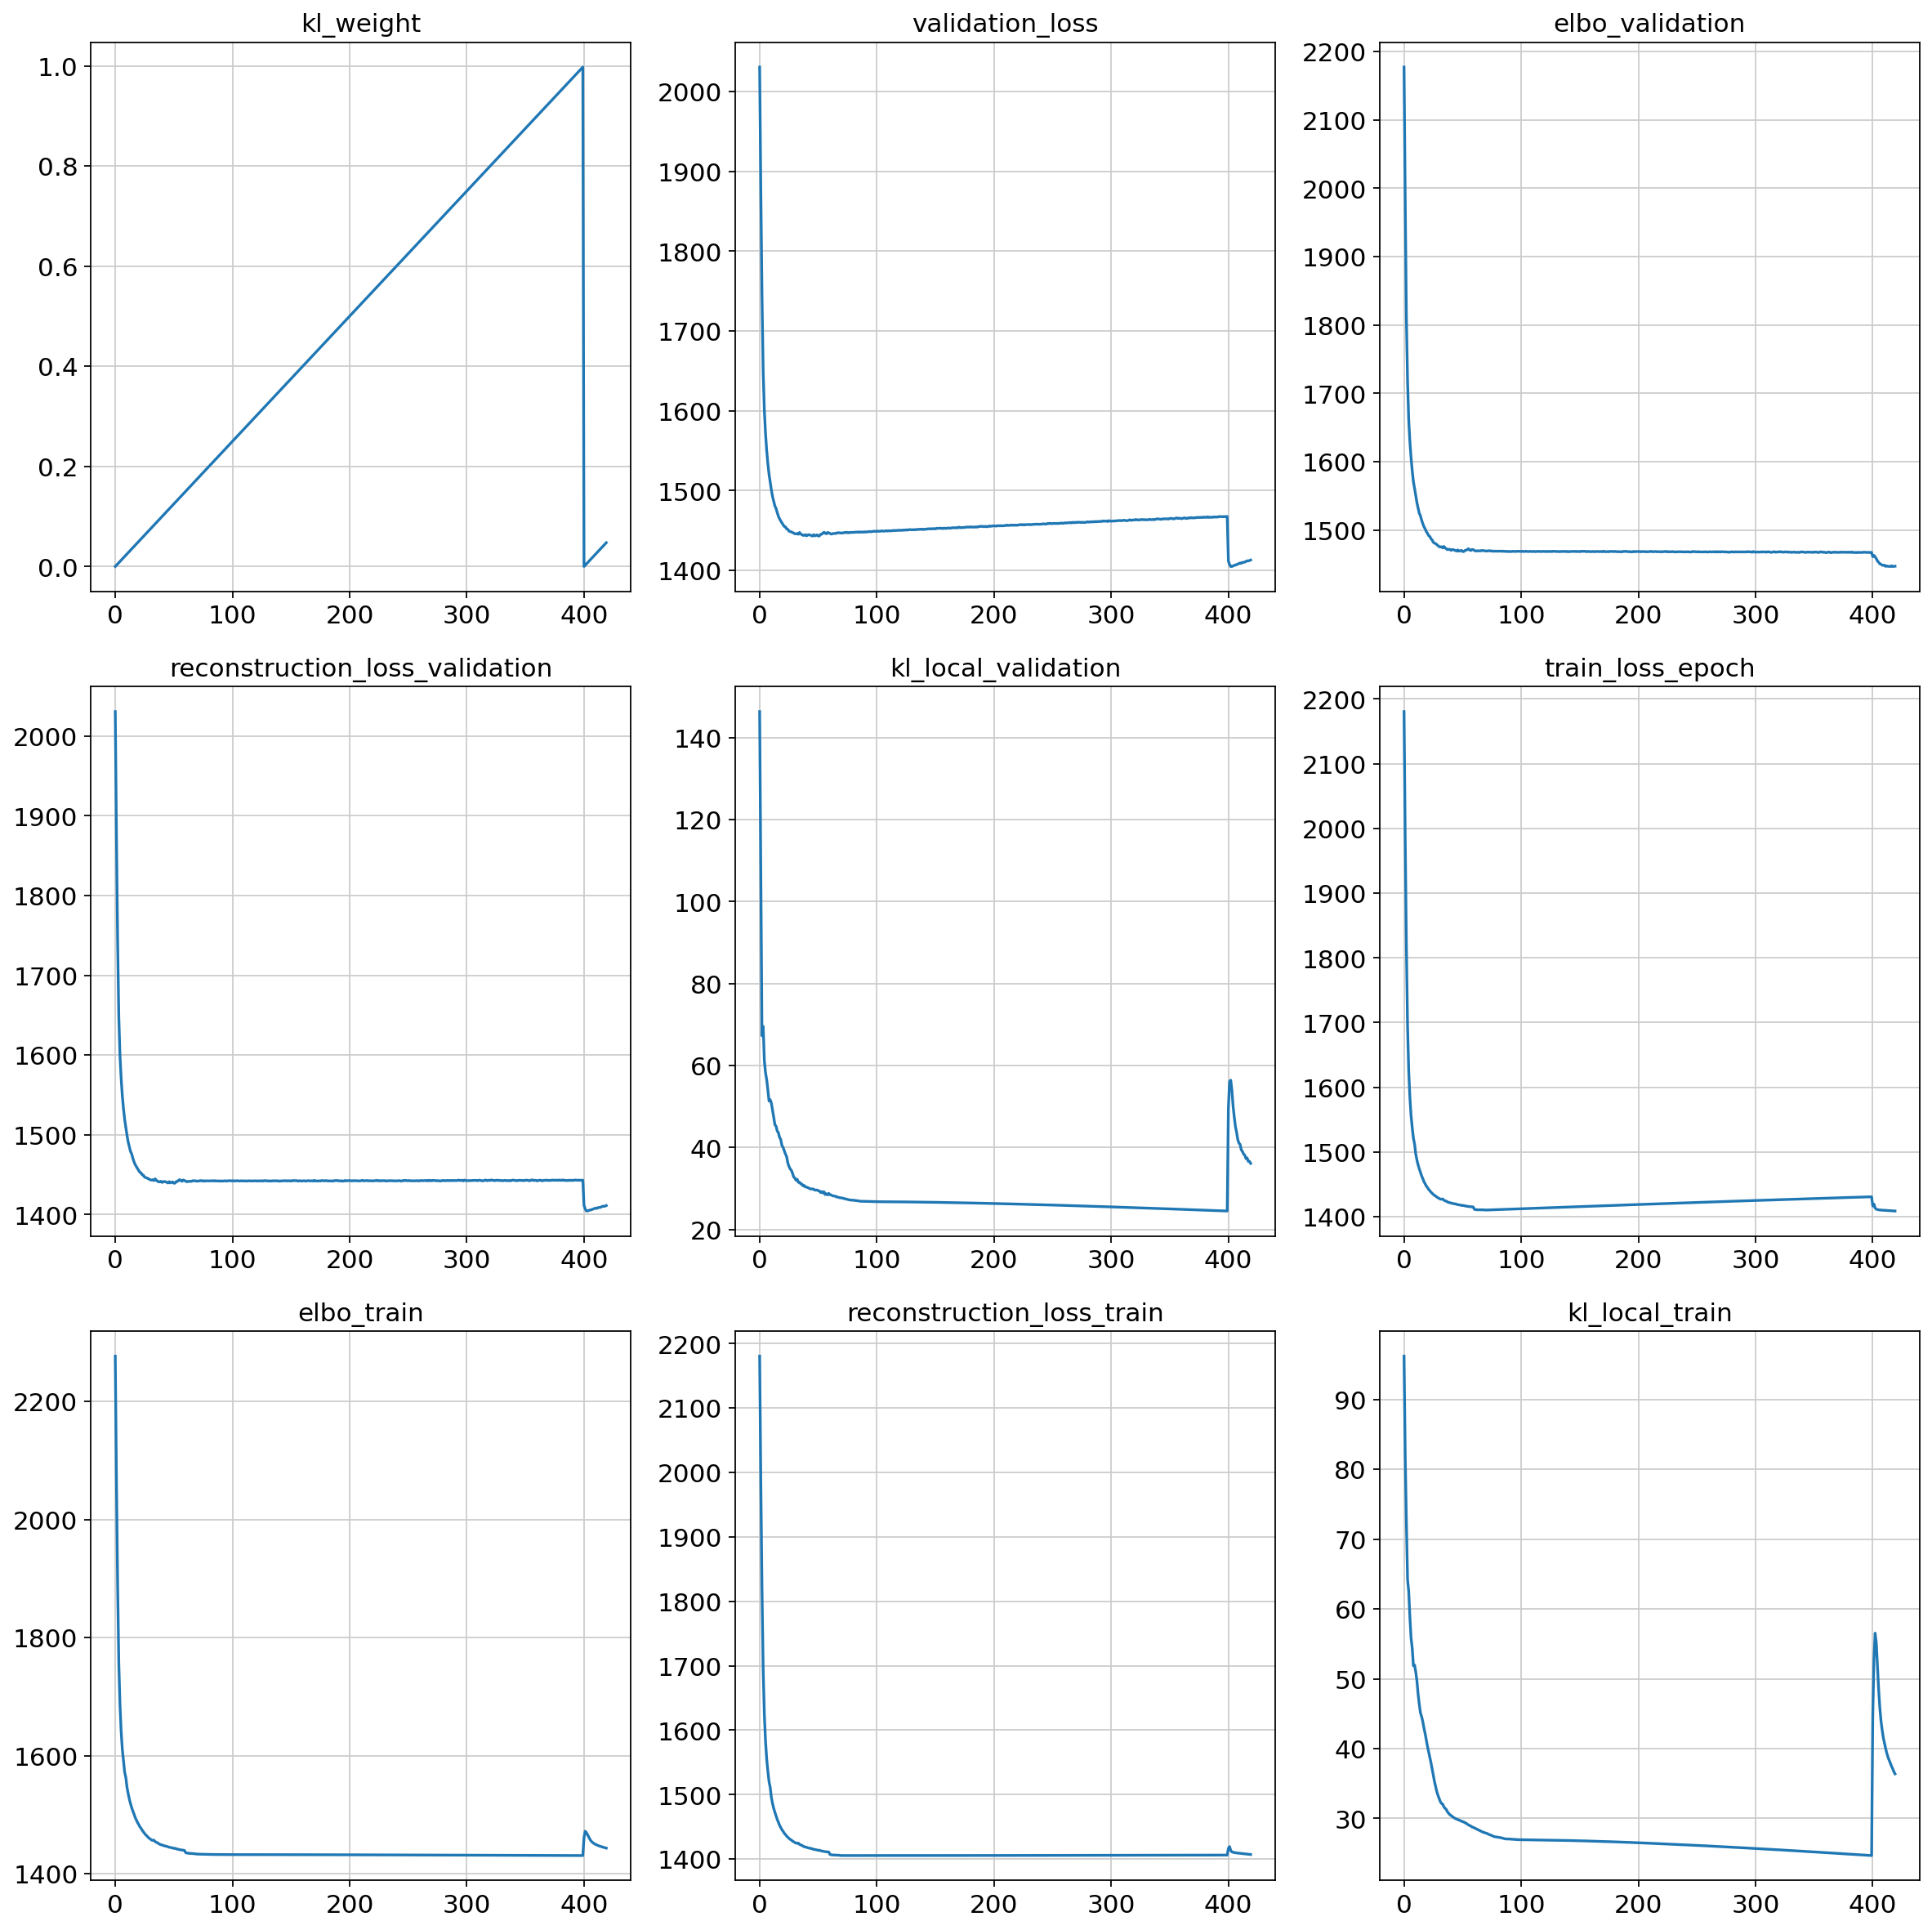

In [76]:
# hidden 512, batch 1024, layers 4, epoch 400 then 20
history_keys = [
    'kl_weight', 'validation_loss', 'elbo_validation', 
    'reconstruction_loss_validation', 'kl_local_validation', 
    'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 
    'kl_local_train'
]

# Assuming scanvae.history contains the training history
plot_training_history(vae.history, history_keys)

In [21]:
scanvae = sca.models.SCANVI.from_scvi_model(vae, unlabeled_category = "Unknown")

In [ ]:
early_stopping_kwargs = {
    "early_stopping_monitor": "elbo",
    "early_stopping_patience": 10,
    "early_stopping_min_delta": 0.01,
}
# # This very importanto for actual covnergence... we have seen we tend to hit local minima and this helps i navoiding but only once...  a peridic approach would ve good
plan_kwargs= {
    # "weight_decay": 0.0,
#     "reduce_lr_on_plateau": True,
#     "lr_patience": 8,
#     "lr_factor": 0.1,
}


scanvae.train(max_epochs=300, early_stopping=early_stopping_kwargs, plan_kwargs=plan_kwargs, batch_size=128)

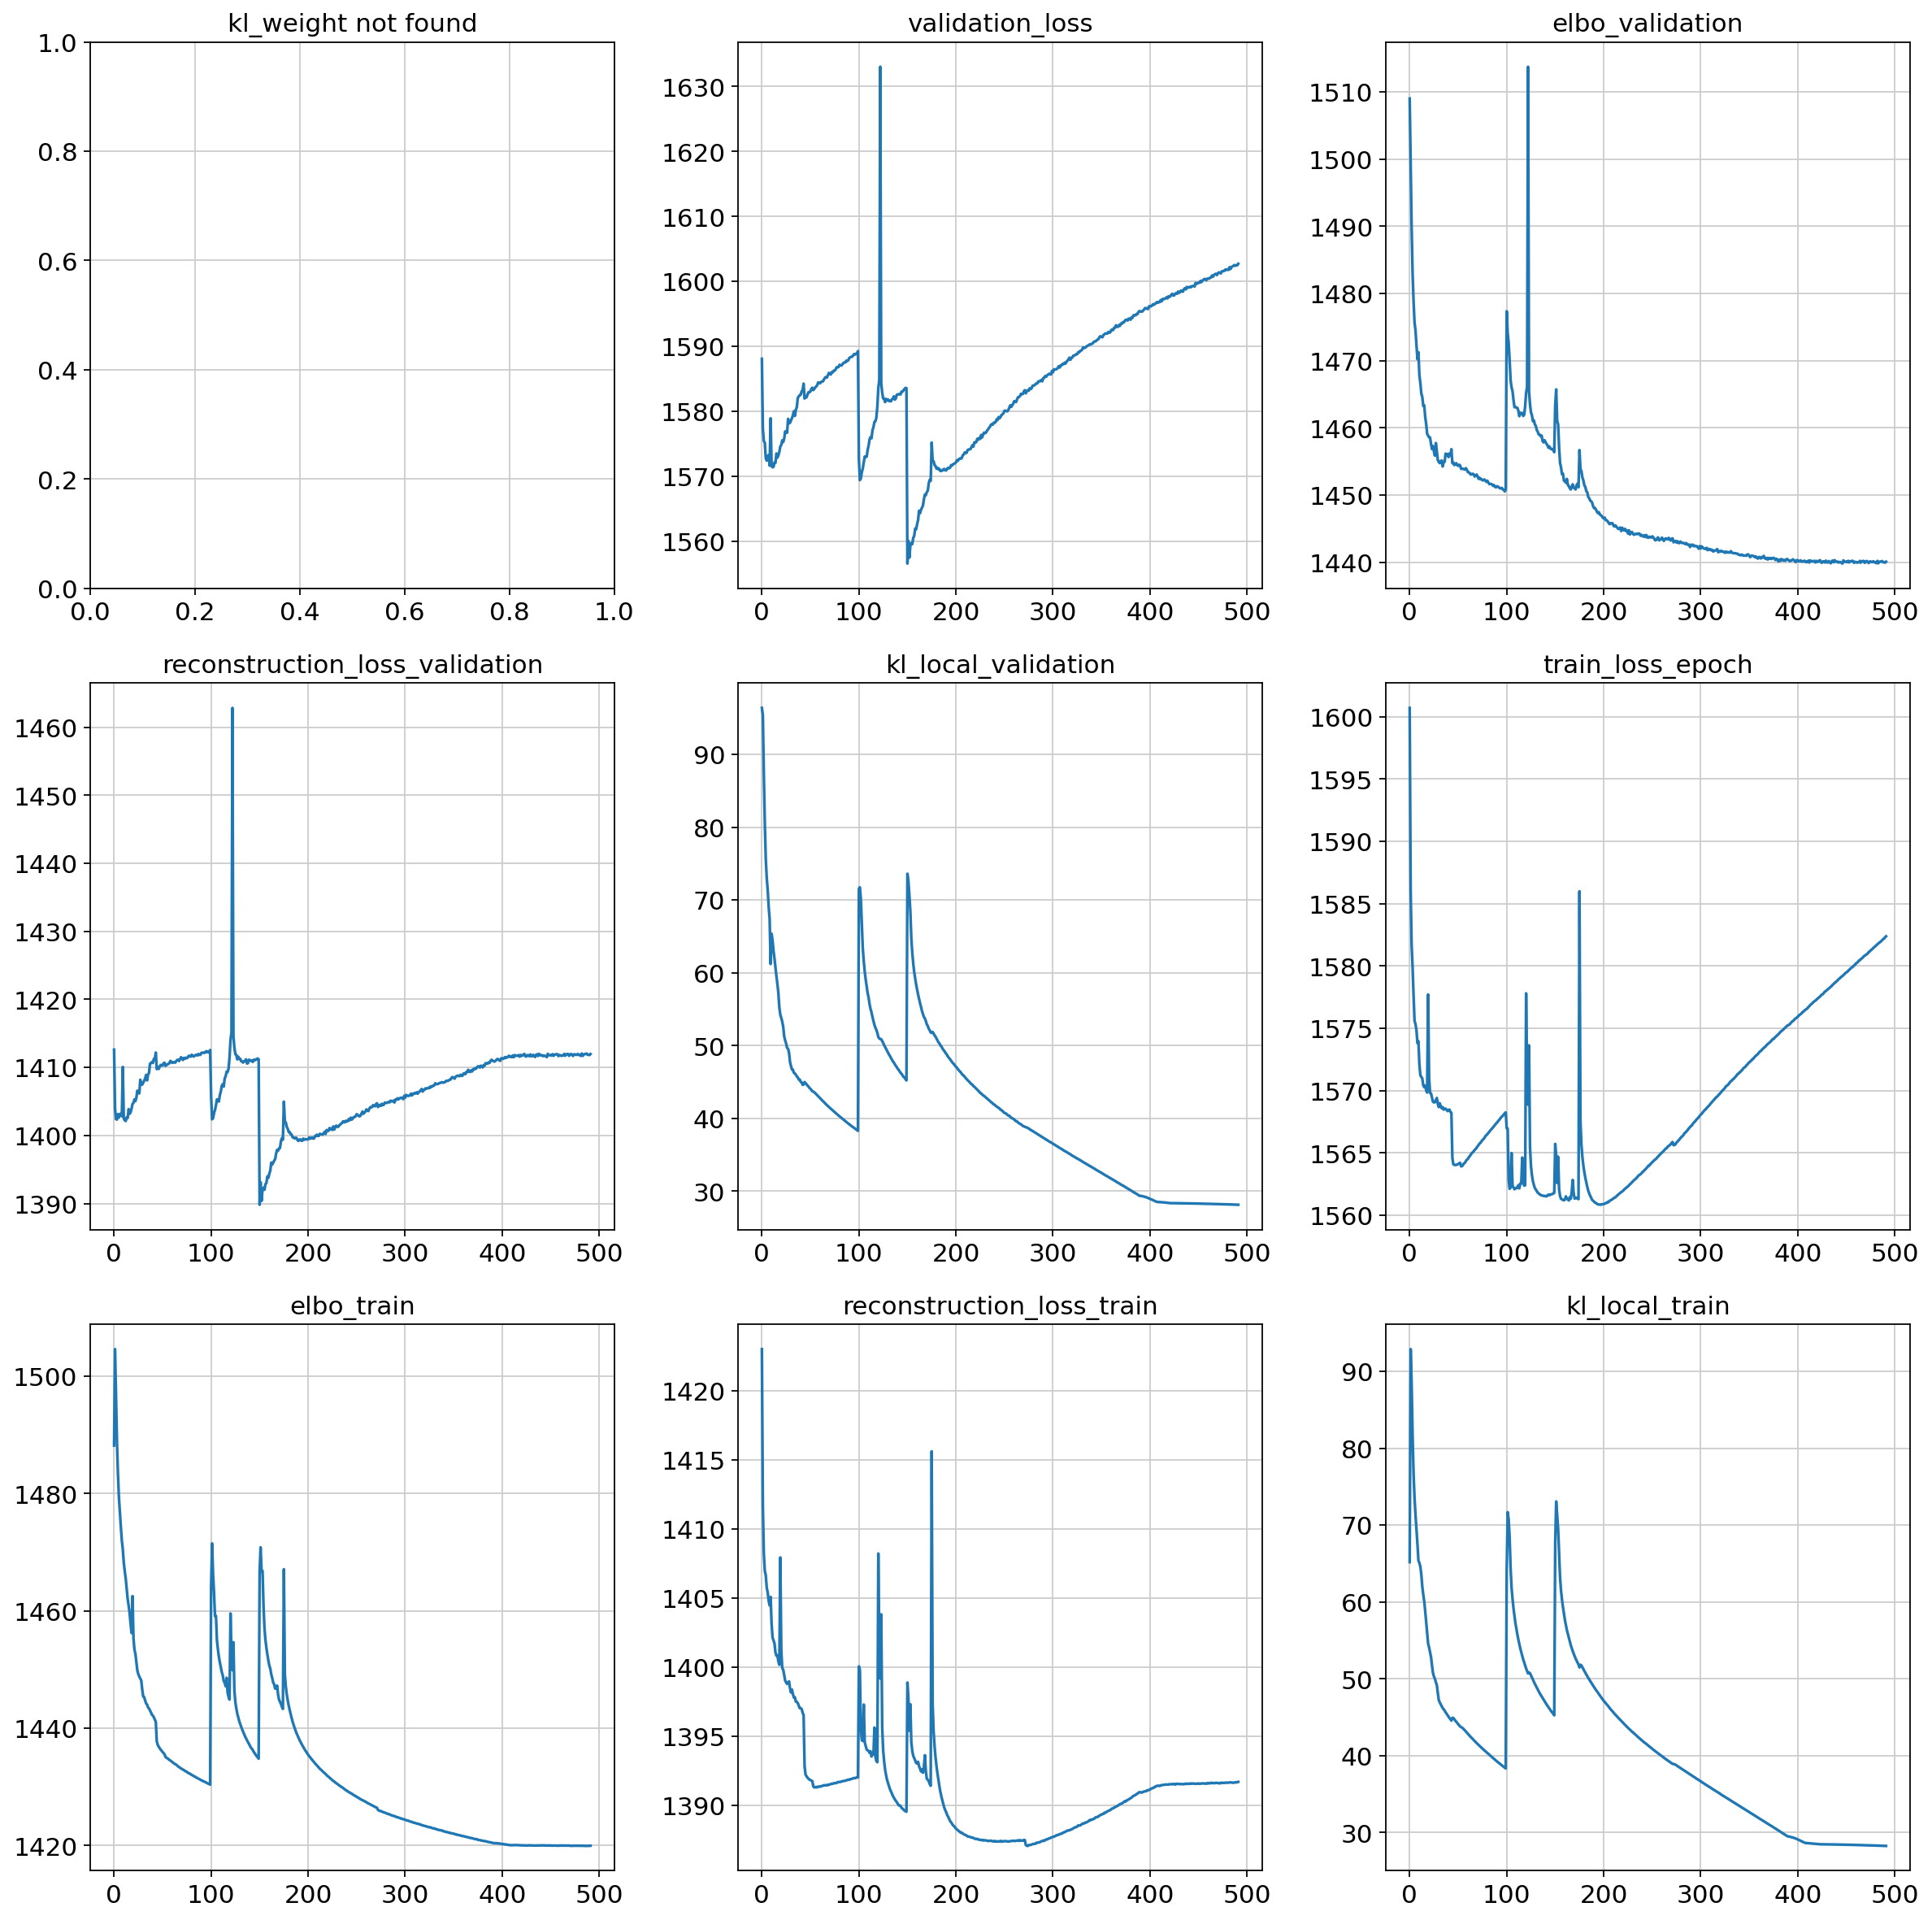

In [80]:
# 1 time vae 100 epoch, 512 bsize, 4 layers; 2 times scanvae 100-400
history_keys = [
    'kl_weight', 'validation_loss', 'elbo_validation', 
    'reconstruction_loss_validation', 'kl_local_validation', 
    'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 
    'kl_local_train'
]

# Assuming scanvae.history contains the training history
plot_training_history(scanvae.history, history_keys)

## Create anndata file of latent representation and compute UMAP

In [37]:
reference_latent = sc.AnnData(scanvae.get_latent_representation())
reference_latent.obs["cell_type"] = source_adata.obs[cell_type_key].tolist()
reference_latent.obs["batch"] = source_adata.obs[condition_key].tolist()

In [27]:
reference_latent.write_h5ad(f'{ref_path}/hvg_embed.h5ad')

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


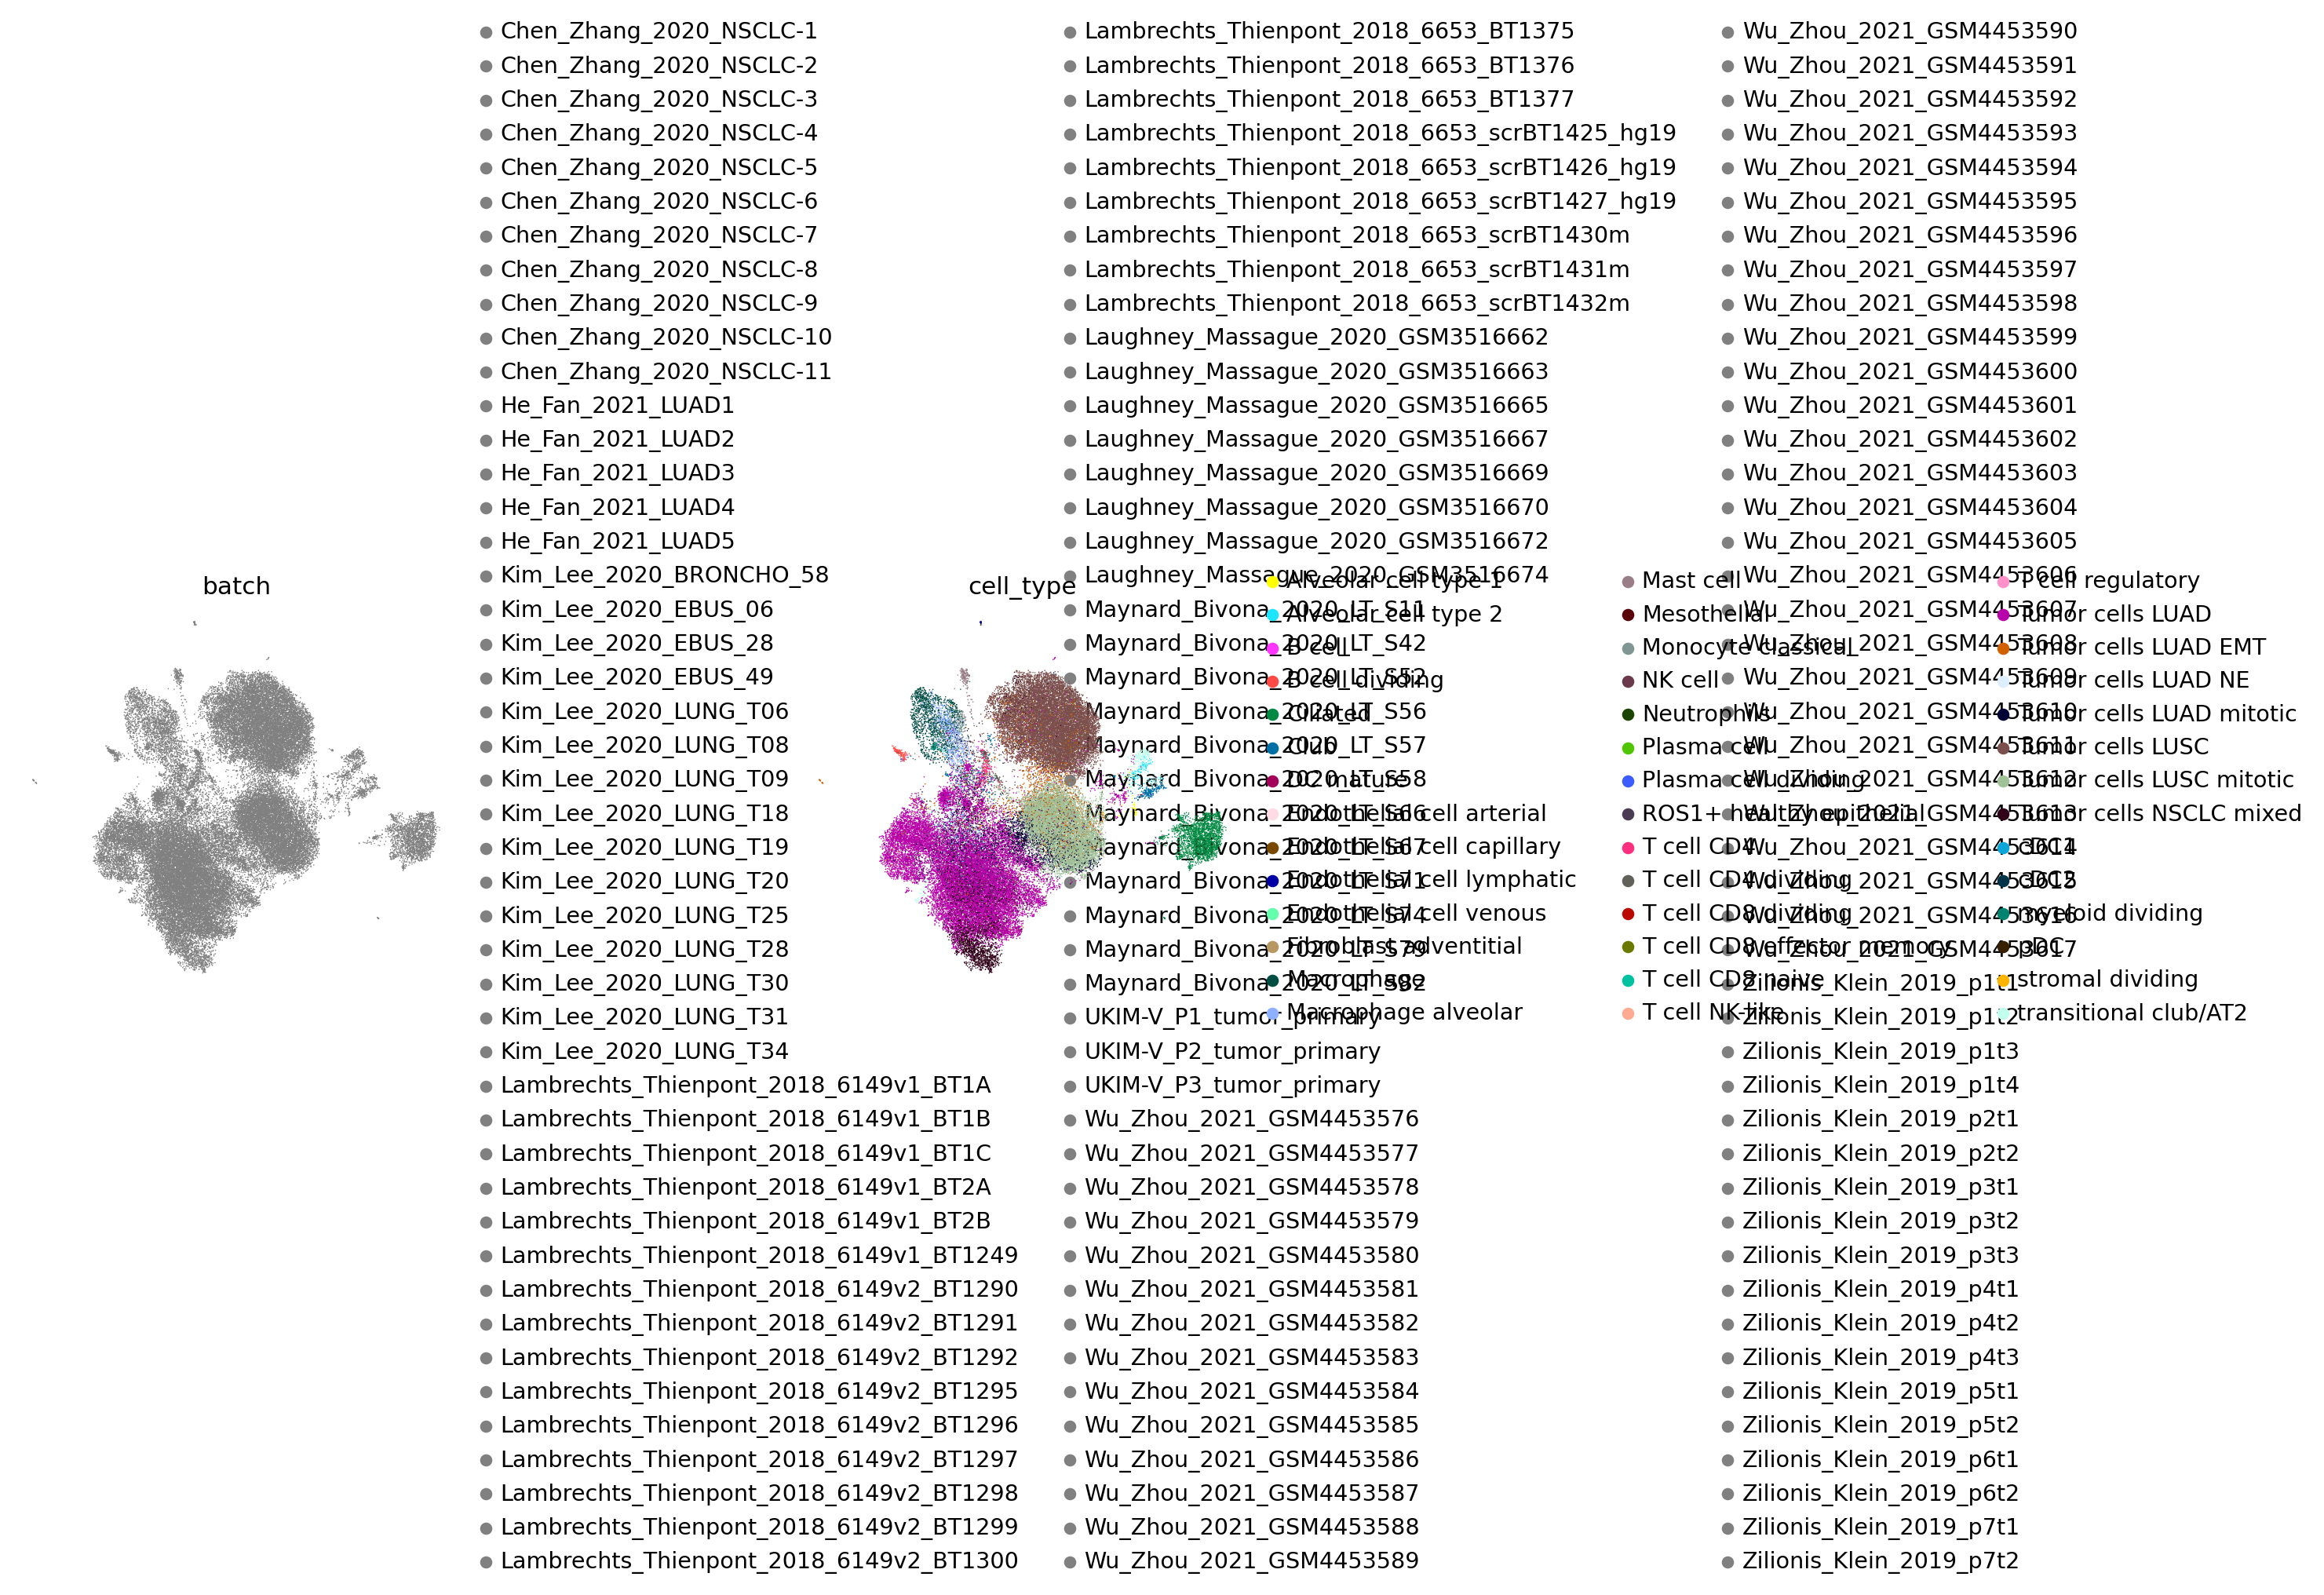

In [111]:
sc.pp.neighbors(reference_latent, n_neighbors=8)
sc.tl.leiden(reference_latent)
sc.tl.umap(reference_latent)
sc.pl.umap(reference_latent,
           color=['cell_type'],
           frameon=False,
           wspace=0.6,
           )

### Various past predictions with no performance graphs

In [12]:
#  2 times vae 3lyaers, batch 1024, size 250-100; 4 times scanvae 100-100-400-200nolradjust batch
reference_latent.obs['predictions'] = scanvae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.cell_type)))

Acc: 0.711986568446778


In [66]:
#  2 times vae 3lyaers, batch 1024, size 250-100; 3 times scanvae 100-100-400 batch
reference_latent.obs['predictions'] = scanvae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.cell_type)))

Acc: 0.7120660450930621


In [61]:
#  2 times vae 3lyaers, batch 1024, size 250-100; 2 times scanvae 100 batch
reference_latent.obs['predictions'] = scanvae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.cell_type)))

Acc: 0.708181624005921


In [53]:
#  2 times vae 3 layers, batch 1024, 1 times scanvae
# reference_latent.obs['predictions'] = scanvae.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.cell_type)))

Acc: 0.704168053368568


In [189]:
# 1 time vae 400 epoch, 128 bsize, 3 layers, no lr adjust; 3 times scanvae 300 epoch
# But on dataset of only tumor cells 67k instead of 4m
reference_latent.obs['predictions'] = scanvae2.predict()
print("Acc: {}".format(np.mean(reference_latent.obs.predictions == reference_latent.obs.cell_type)))

Acc: 0.904988161515326


### Recover past trainings with no adata

In [45]:
from scvi.model.base._utils import _load_saved_files
attr_dict, var_names, model_state_dict, adata_ = _load_saved_files(
    '/root/datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_scanvi_tumor_model_layers4/',
    load_adata=False, map_location='cpu')
attr_dict

INFO     File                                                                                                      
         /root/datos/maestria/netopaas/lung_scRNA/LUCA_model/hvg_integrated_scvi_scanvi_tumor_model_layers4/model.p
         t already downloaded                                                                                      


{'history_': {'train_loss_step':       train_loss_step
  epoch                
  0         1618.816284
  1         1551.252686,
  'validation_loss':       validation_loss
  epoch                
  0         1579.084106,
  'elbo_validation':       elbo_validation
  epoch                
  0         1500.672363,
  'reconstruction_loss_validation':       reconstruction_loss_validation
  epoch                               
  0                        1403.753418,
  'kl_local_validation':       kl_local_validation
  epoch                    
  0               96.919006,
  'kl_global_validation':       kl_global_validation
  epoch                     
  0                      0.0,
  'validation_classification_loss':       validation_classification_loss
  epoch                               
  0                           3.506613,
  'validation_accuracy':       validation_accuracy
  epoch                    
  0                0.458287,
  'validation_f1_score':       validation_f1_score
  epo